# Прогнозирование температуры звезды

<font size="3"> Обсерватория «Небо на ладони» внедряет технологии машинного обучения для предсказания температуры звёзд.

Для проведения исследования доступны характеристики уже изученных 240 звёзд.

Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

**План проведения исследования:**
- изучим данные;
- проведём предобработку;
- выполним исследовательский и корреляционный анализ данных;
- построим простую модель нейронной сети — baselinе;
- улучшим baselinе-модель перебором параметров;
- для оценки качества моделей используем метрику RMSE - итоговая матрика не должна превышать 4500.

---
## Загрузка и чтение данных

### Подготовка к чтению данных

<font size="3"> Импортируем необходимые библиотеки:

In [ ]:
pip install skorch torchsummary missingno phik optuna==3.6 optuna-integration matplotlib==3.8.3 scikit-learn==1.3.0 levenshtein -q

In [ ]:
import math
import os
import random
import re
import sys
import warnings

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import missingno as msno
import numpy as np
import pandas as pd
import phik
from phik.report import plot_correlation_matrix
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as data
from torchsummary import summary

from Levenshtein import distance
import Levenshtein as lev
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from skorch import callbacks
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, EpochScoring
from warnings import simplefilter

import optuna
from optuna import create_study, Trial, distributions

from math import sqrt

# настройки Pandas
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format ='{:,.3f}'.format
pd.options.display.colheader_justify = 'left'
pd.set_option('display.max_columns', None)

# параметры констант в блокноте
RANDOM_STATE = 12345
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)

# настройки графиков
PLOT_DPI = 150
plt.rcParams['figure.dpi'] = PLOT_DPI
sns.set(style="darkgrid", rc = {'figure.figsize' : (12, 6)})
my_palette = sns.color_palette(
    [
        "#77aabb",
        "#88b1b9",
        "#99b9b6",
        "#aac0b4",
        "#bbc7b1",
        "#ccceaf",
        "#ddd6ac",
        "#eeddaa",
    ]
)
sns.set_palette(my_palette)

# остальные настройки
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore")

### Чтение данных

<font size="3"> Считаем полученные характеристики звёзд и сохраним в переменную `stars`:

In [ ]:
stars = pd.read_csv('/datasets/6_class.csv')

<font size="3"> Выведем первые 20 строчек датафрейма `stars` на экран:

In [ ]:
stars.head(20)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002,0.170,16.120,0,Red
1,1,3042,0.001,0.154,16.600,0,Red
2,2,2600,0.000,0.102,18.700,0,Red
3,3,2800,0.000,0.160,16.650,0,Red
4,4,1939,0.000,0.103,20.060,0,Red
5,5,2840,0.001,0.110,16.980,0,Red
6,6,2637,0.001,0.127,17.220,0,Red
7,7,2600,0.000,0.096,17.400,0,Red
8,8,2650,0.001,0.110,17.450,0,Red
9,9,2700,0.000,0.130,16.050,0,Red


### Изучение данных

<font size="3"> Изучим структуру и полноту полученных данных.

In [ ]:
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


<Axes: >

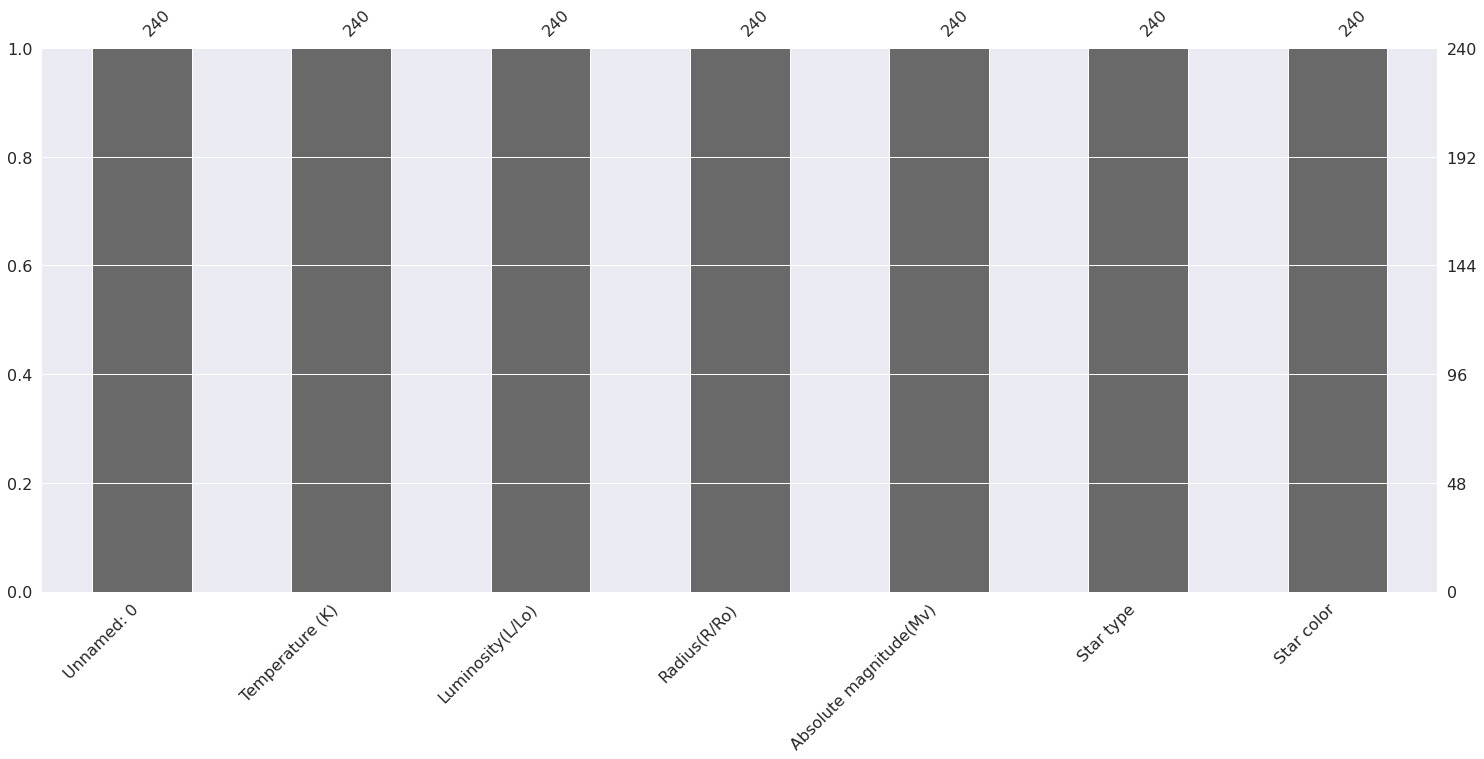

In [ ]:
msno.bar(stars)

<font size="3">
    
**Вывод раздела:**

Полученный датафрейм 240 наблюдений и 6 признаков:

**Признаки**
* `Unnamed` — порядковый номер
* `Luminosity` — светимость звезды относительно Солнца (L/Lo) - числовой непрерывный признак;
* `Radius` — радиус звезды относительно радиуса Солнца (R/Ro) - числовой непрерывный признак;
* `Absolute magnitude` — физическая величина, характеризующая блеск звезды (Mv) - числовой непрерывный признак;
* `Star color` — цвет звезды, который определяют на основе спектрального анализа - категориальный порядковый признак;
* `Star type` — тип звезды - категориальный строковый признак:


| Тип звезды | Номер, соответствующий типу |
|----------|----------|
| Коричневый карлик    | 0   |
| Красный карлик   | 1   |
| Белый карлик    | 2   |
| Звёзды главной последовательности    | 3  |
| Сверхгигант    | 4   |
| Гипергигант    | 5   |


⠀**Целевой признак**
* `Temperature` — температура на поверхности звезды (в Кельвинах) - числовой дискретный признак.

Предварительно можно утверждать, что для проведения исследования получено мало данных, может потребоваться увеличение выборки.
    
Столбцы датафрейма следует переименовать в соответствии с PEP8.

Пропущенные значения отсутствуют.
    
Стоит подробнее изучить тип имеющихся данных, а также в данных могут присутствовать дубликаты.

---

## Предобработка данных

<font size="3"> Проведём предобработку данных.

### Отбор признаков

<font size="3"> Удалим столбец `Unnamed: 0`, повторяющий индекс, так как он не несёт в себе ценной для исследования информации.

In [ ]:
# сохраним копию датафрейма до изменений
stars_raw = stars.copy()

del stars['Unnamed: 0']

#проверим результат
stars.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

<font size="3">


Неинформативный столбец удалён.

### Именование столбцов


<font size="3"> Приведём названия столбцов датафрейма к стандарту: сделаем нижний регистр и разделим слова по символу "_". Дополнительно удалим меры измерения из заголовков.

In [ ]:
stars.columns = [
    re.sub(r'\s*\([^)]*\)', '', column)
    .replace('(k)', '')
    .replace('(l/lo)', '')
    .replace('(r/ro)', '')
    .replace('(mv)', '')
    .replace(' ', '_', 1)
    .lower()
    for column in stars.columns
]

#проверим результат
stars.columns

Index(['temperature', 'luminosity', 'radius', 'absolute_magnitude',
       'star_type', 'star_color'],
      dtype='object')

<font size="3">

Столбцы датафрейма именованы корректно.

### Тип данных


<font size="3"> Убедимся, что все данные имеют корретный тип.

In [ ]:
stars.dtypes

temperature             int64
luminosity            float64
radius                float64
absolute_magnitude    float64
star_type               int64
star_color             object
dtype: object

<font size="3">

Все столбцы датафрейма содержат корректный тип данных:
    
- `temperature` — числовой дискретный признак | тип данных `int`;
- `luminosity` —  числовой непрерывный признак | тип данных `float`;
- `radius` — числовой непрерывный признак | тип данных `float`;
- `absolute_magnitude` — числовой непрерывный признак | тип данных `float`;
- `star_type` — категориальный порядковый признак | тип данных `int`;
- `star_color` — категориальный строковый признак | тип данных `object`.

### Проверка неявных дубликатов

<font size="3"> Проверим значения категориальных столбцов датафрейма на уникальность.

<font size="3">
    
- признак **'star_type'**

In [ ]:
stars['star_type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

<font size="3"> Неявные дубликаты отсутствуют.

<font size="3">
    
- признак **'star_color'**

In [ ]:
stars['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Blue white              3
Yellowish White         3
Whitish                 2
yellowish               2
Orange                  2
Blue                    1
Yellowish               1
Blue white              1
White-Yellow            1
Pale yellow orange      1
Blue-White              1
Orange-Red              1
Name: star_color, dtype: int64

<font size="3"> Признак содержит неявные дубликаты.

Сначала приведём записи к нижнему регистру и избавимся от символов:

In [ ]:
stars['star_color'] = stars['star_color'].str.strip().str.lower().replace({'-': ' '}, regex=True)

# проверим результат
stars['star_color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
yellow white            8
yellowish               3
yellowish white         3
orange                  2
whitish                 2
pale yellow orange      1
white yellow            1
orange red              1
Name: star_color, dtype: int64

<font size="3"> Признак содержит неявные дубликаты, рассмотрим подробнее частично совпадающие категории:

In [ ]:
colors = stars['star_color'].unique()

threshold = 0.5  # порог сходства
similar_colors = {}
already_printed = set()

for c in colors:
    similar_colors[c] = []
    for s in colors:
        if c != s and distance(c, s) < math.ceil(len(c) * threshold):
            similar_colors[c].append(s)

    if similar_colors[c]:
        for color in similar_colors[c]:
            if color not in already_printed:
                print(c, similar_colors[c])
                already_printed.add(c)
                already_printed.update(similar_colors[c])

yellowish white ['yellow white', 'yellowish']
whitish ['white']
yellow white ['blue white', 'yellowish white', 'yellowish']
orange red ['orange']


<font size="3"> Также в выборке присутствуют неопределённые цвета звёзд, устраним неявные дубликаты и определим объекты в стандартные спектральные классы:
    
- `white yellow` на `yellow white`
- `yellowish white` на `yellow white`
- `yellowish` на `yellow`
- `whitish` на `white`
- `pale yellow orange` на `yellow`
- `orange red` на `orange`
- `orange white` на `orange`

In [ ]:
stars['star_color'] = (
    stars['star_color'].replace(['white yellow', 'yellowish white'], 'yellow white', regex=True)
    .replace(['yellowish'], 'yellow', regex=True)
    .replace(['whitish'], 'white', regex=True)
    .replace(['pale yellow orange'], 'yellow', regex=True)
    .replace(['orange red'], 'orange', regex=True)
    .replace(['orange white'], 'orange', regex=True)
)

#проверим результат
stars['star_color'].value_counts()

red             112
blue             56
blue white       41
yellow white     12
white            12
yellow            4
orange            3
Name: star_color, dtype: int64

<font size="3"> Неявные дубликаты устранены, все записи приведены к единому стандарту спектральных классов звёзд.

### Проверка явных дубликатов

<font size="3"> Проверим наличие явных дубликатов в датафрейме.

In [ ]:
stars.duplicated().sum()

0

<font size="3">



Явные дубликаты отсутствуют.

---

<font size="3">

**Вывод раздела**

Для корректного проведения исследования выполнена предобработка данных:

- отобраны информативные признаки;
- столбцы именованы корректно;
- проверены типы данных;
- проверены дубликаты в датафреймах, в том числе и неявные.

---
## Исследовательский анализ данных

<font size="3"> Проведём исследовательский анализ признаков датафрейма.

### Количественные признаки

<font size="3"> Напишем функцию `visuals`, которая построит гистограмму распределения, коробчатую диаграмму и выведет метод `describe()`:

In [ ]:
def visuals(cat):
    display(stars[cat].describe())

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6), dpi=PLOT_DPI)

    stars[cat].plot(kind='hist', bins=20, ax=axes[0])
    axes[0].set_title('Гистограмма распределения', fontsize=14)
    axes[0].set_ylabel('Частота встречаемости')
    axes[0].set_xlabel('Наблюдаемые значения')

    stars[cat].plot(kind='box', ax=axes[1], rot=0)
    axes[1].set_title('Разброс значений признаков', fontsize=14)
    axes[1].set_xlabel('Категория')
    axes[1].set_ylabel('Наблюдаемые значения')

<font size="4">
    
> Целевой признак **temperature**

count      240.000
mean    10,497.462
std      9,552.425
min      1,939.000
25%      3,344.250
50%      5,776.000
75%     15,055.500
max     40,000.000
Name: temperature, dtype: float64

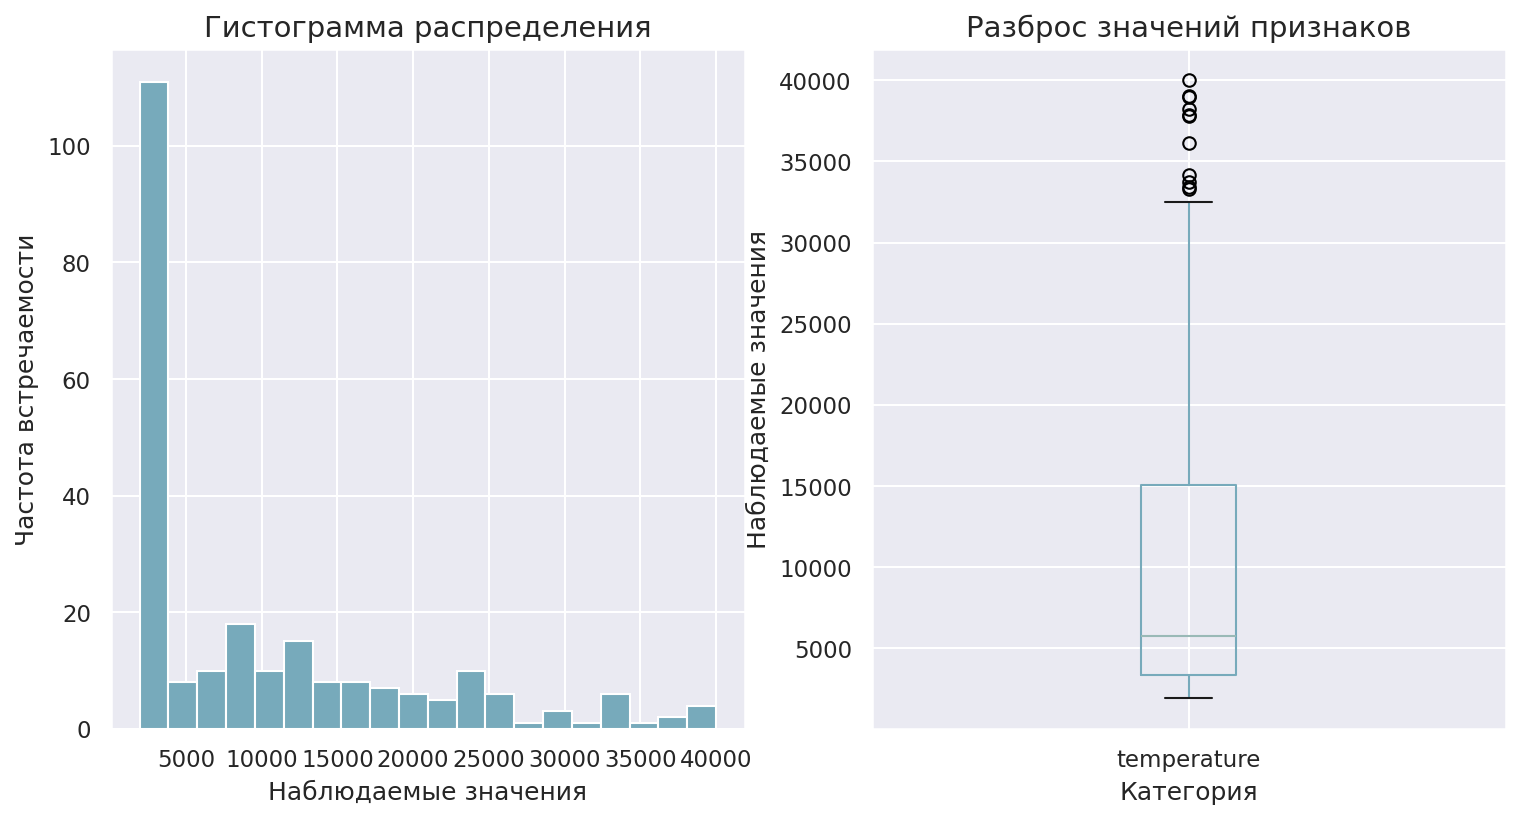

In [ ]:
visuals('temperature')

<font size="3">
    
**Вывод**

Признак `temperature` - целевой, температура на поверхности звезды в Кельвинах.
    
Распределение признака асимметрично вправо с длинным хвостом, среднее значение больше, чем медиана.
    
Большинство значений располагается в промежутке от 1 939 до 15 055 Кельвинов, пик находится в районе 3 000 К с резким спадом и плавным затуханием.
    
Можно сделать вывод, что в выборке преобладают звёзды с температурой в диапазоне 2000-4000 Кельвинов, возможно это связано с тем, что подобные звёзды чаще встречаются в ближайшем пространстве.
        
Также можно отметить звёзды с очень высокой температурой от 35 000 Кельвинов - изучим их подробнее на корреляционном анализе, возможно "горячие" звёзды представляют собой отдельный кластер со своими характеристиками и не являются выбросами.

<font size="4">
    
> Признак **luminosity**

count       240.000
mean    107,188.362
std     179,432.245
min           0.000
25%           0.001
50%           0.071
75%     198,050.000
max     849,420.000
Name: luminosity, dtype: float64

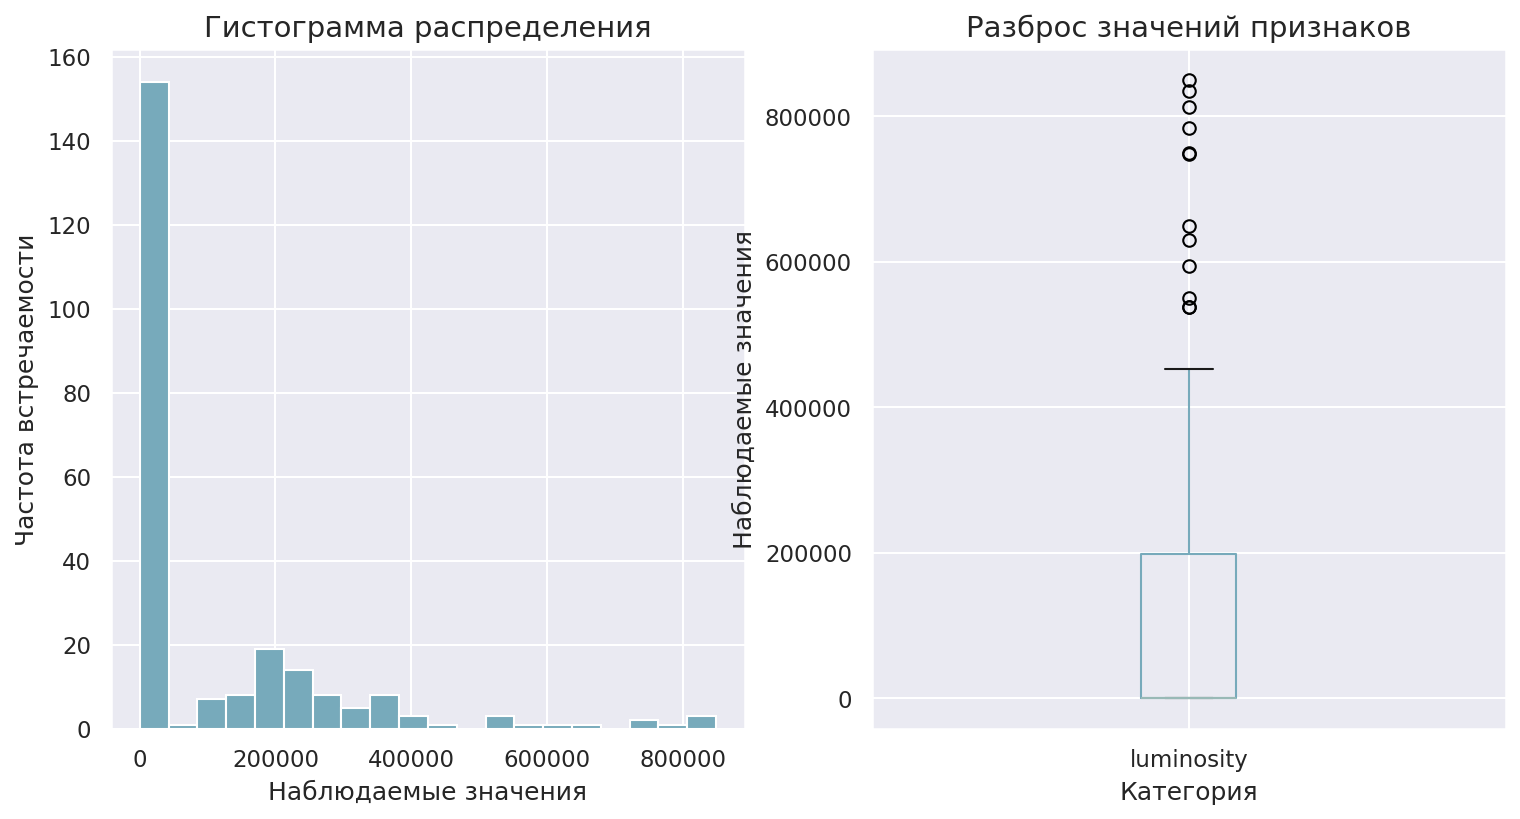

In [ ]:
visuals('luminosity')

<font size="3">
    
**Вывод**

Признак `luminosity` - светимость звезды относительно Солнца.

Распределение признака асимметрично вправо с длинным хвостом, среднее значение больше, чем медиана.

Большинство значений располагается в промежутке от 0.001 до 198 050 L/Lo.

Половина звезд в датасете имеют светимость меньше, чем 0.071 L/Lo. Это довольно низкая светимость, которая соответствует красным карликам. Максимум в 849 420 L/Lo - очень высокая светимость, которая может быть характерна для сверхгигантов.
    
Рассмотрим подробнее сопряжённость температуры звезды и её светимости в корреляционном анализе далее.

<font size="4">
    
> Признак **radius**

count     240.000
mean      237.158
std       517.156
min         0.008
25%         0.103
50%         0.762
75%        42.750
max     1,948.500
Name: radius, dtype: float64

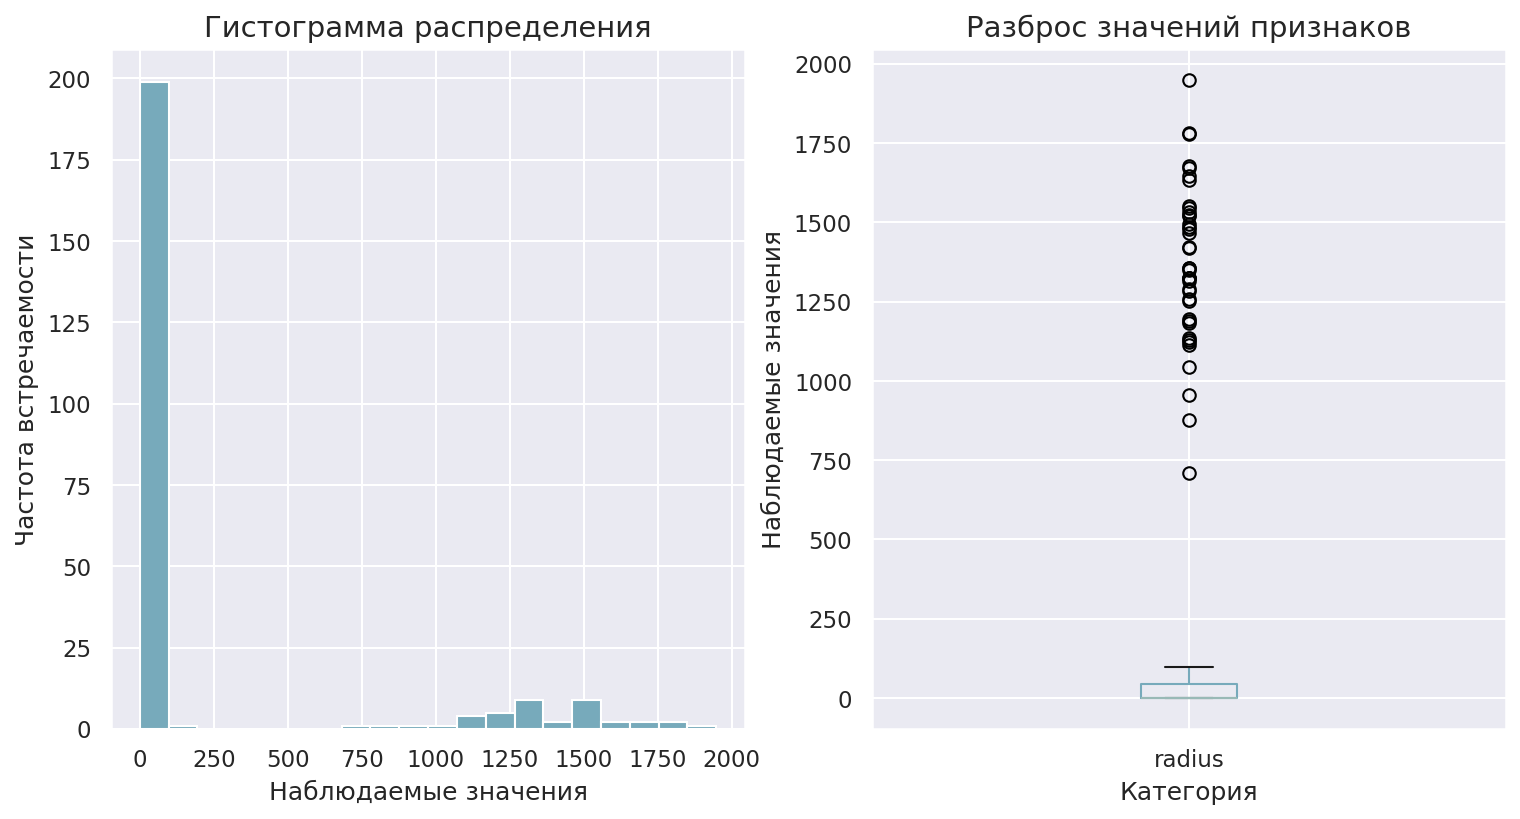

In [ ]:
visuals('radius')

<font size="3">
    
**Вывод**

Признак `radius` - радиус звезды относительно радиуса Солнца.

Большинство значений располагается в промежутке от 0.103 до 42.750 R/Ro.    
    
При этом на графиках отмечаются выбросы: максимальное значение радиуса в датасете - 1948.500 R/Ro, что в 45 раз больше 75% квартиля.
    
Звезды с таким огромным радиусом очень редки. Они относятся к категории сверхгигантов или гипергигантов и встречаются в космосе не так часто.
    
Изучим выбросы признака подробнее на этапе корреляционного анализа.

<font size="4">
    
> Признак **absolute_magnitude**

count   240.000
mean      4.382
std      10.533
min     -11.920
25%      -6.232
50%       8.313
75%      13.697
max      20.060
Name: absolute_magnitude, dtype: float64

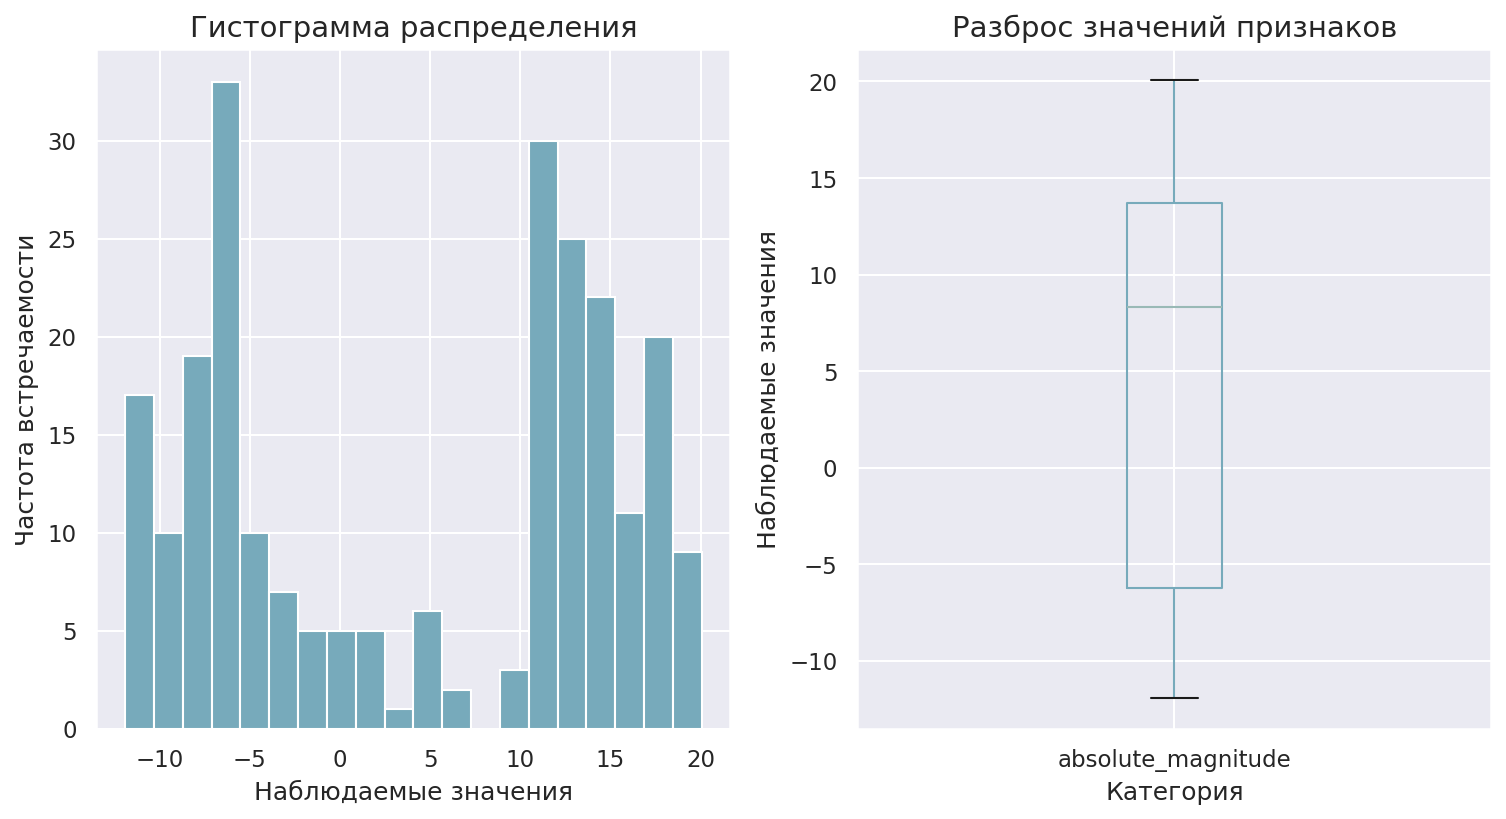

In [ ]:
visuals('absolute_magnitude')

<font size="3">
    
**Вывод**

Признак `absolute_magnitude` - абсолютная звёздная величина, характеризующая блеск звезды.
    
Распределение признака бимодально, большинство значений располагается в промежутке от -6.232 до 13.697 Mv.
    
Данные выглядят неправдоподобно:
- минимум в -11.920 - это невероятно яркая звезда. Самая яркая звезда в нашей галактике (Сириус) имеет абсолютную величину около +1,4 Mv;
- максимум в 20.060 - это очень тусклая звезда, практически незаметная для наших телескопов.
    
Изучим выбросы признака подробнее на этапе корреляционного анализа.

---

### Категориальные признаки

<font size="3">  
    
Изучим категориальные признаки датафрейма `stars`.

Напишем функцию `cat_visuals`, которая визуализирует признак с помощью столбчатой гистограммы.

In [ ]:
def cat_visuals(cat):
    plt.figure(dpi=PLOT_DPI)

    ax = sns.countplot(x=stars[cat],
                   order=stars[cat].value_counts(ascending=False).head(10).index);

    abs_values = stars[cat].value_counts(ascending=False).head(10).values

    ax.bar_label(container=ax.containers[0], labels=abs_values)
    ax.set_title('Распределение категорий признака ' + cat, fontsize=14)
    ax.set(xlabel='Категории', ylabel='Частота встречаемости')
    ax.figure.set_size_inches(20,8)

<font size="4">
    
> Признак **star_type**

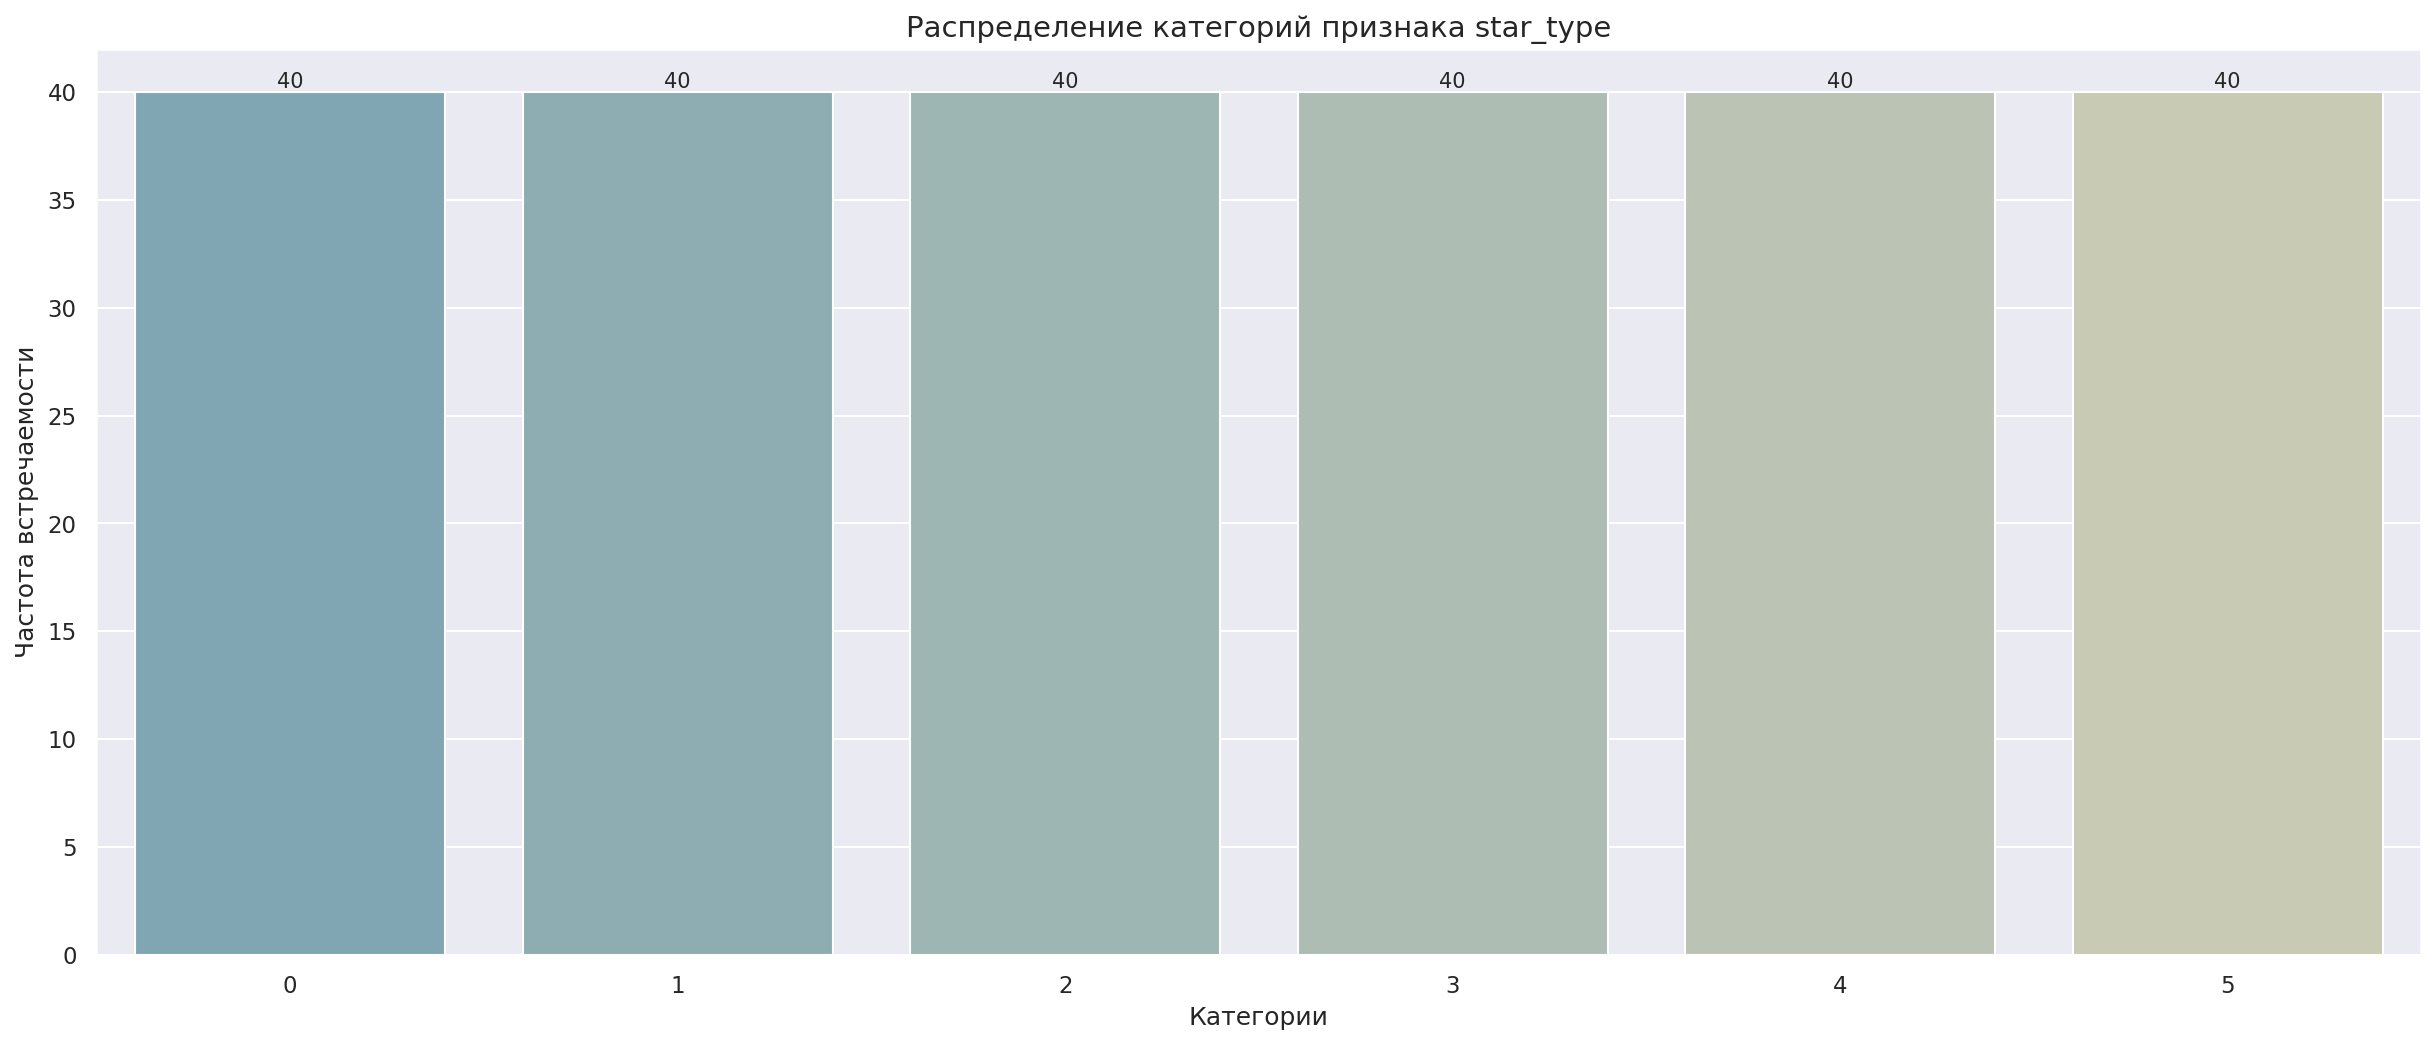

In [ ]:
cat_visuals('star_type')

<font size="3">
    
**Вывод**

Признак `star_type` представлен категориями:
- 0 - Коричневый карлик         
- 1 - Красный карлик       
- 2 - Белый карлик       
- 3 - Звёзды главной последовательности         
- 4 - Сверхгигант   
- 5 - Гипергигант     
    
Похоже, что выборка стратифицирована по типу звезд: имеется 40 объектов каждого типа звёзд.

<font size="4">
    
> Признак **star_color**

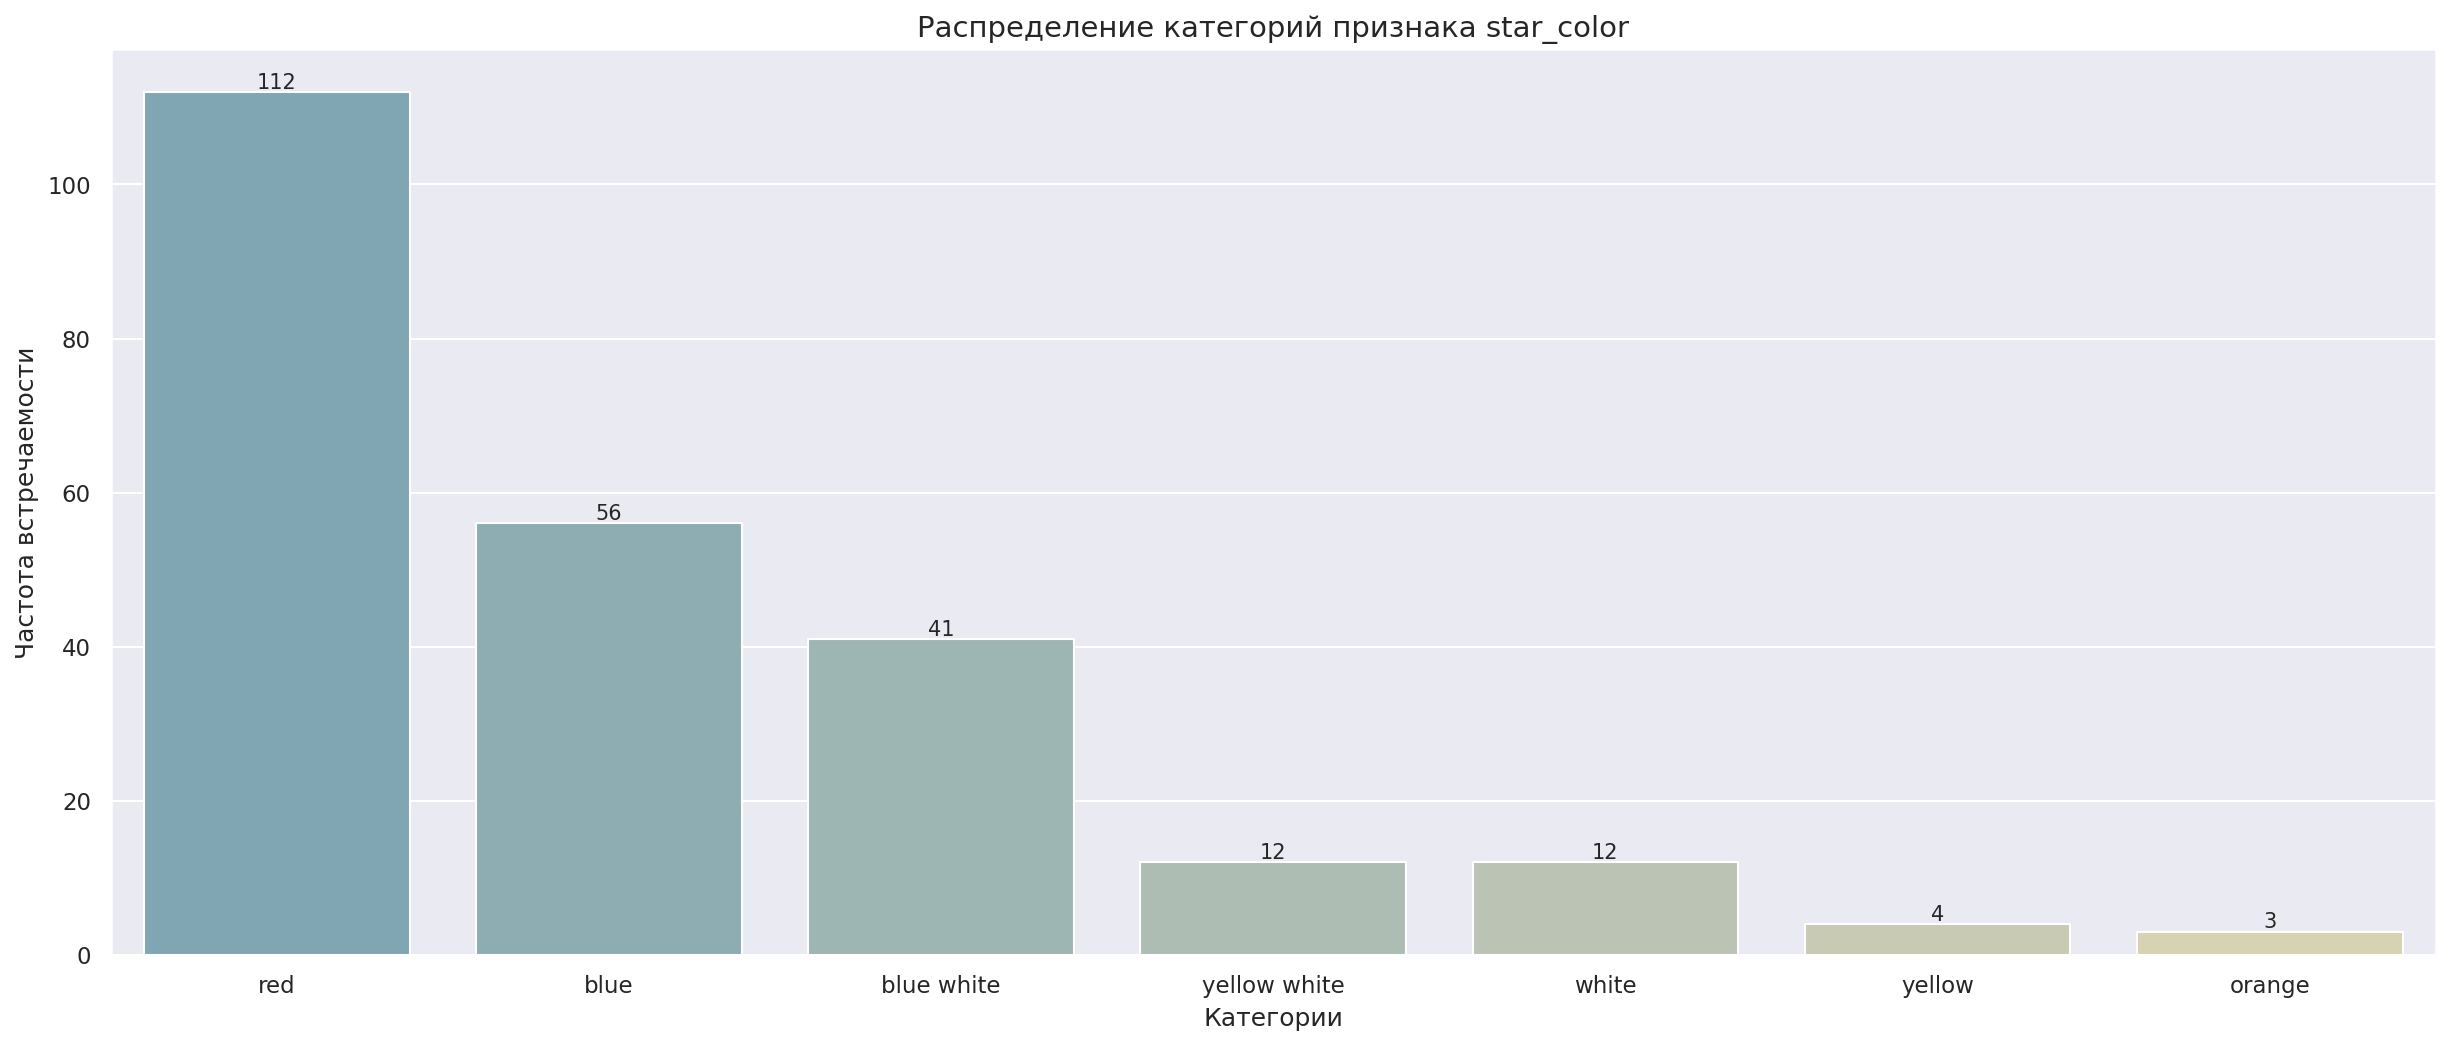

In [ ]:
cat_visuals('star_color')

<font size="3">
    
**Вывод**

Признак `star_color` представлен категориями:
- red         
- blue       
- blue white               
- yellow white
- white
- yellow    
- orange     
    
В выборке значительно преобладают звёзды цвета «red».

---
<font size="3">

**Вывод раздела**

В датафрейме `stars` 2 категориальных и 4 количественных признака, включая целевой.
    
В данных присутствуют выбросы и аномалии, изучим их подробнее в корреляционном анализе.

---

## Корреляционный анализ

<font size="3"> Проведём корреляционный анализ признаков датафрейма.

Признак `temperature` - целевой, изучим взаимосвязь входных признаков с целевым, а также выявим мультиколлинеарность признакового описания при его наличии.

### Целевой признак

<font size="3"> Рассмотрим сопряжённость целевого признака со всеми признаками датафрейма.

<font size="3"> **Количественные признаки**
    

Напишем функцию `target_num` для построения графика `scatterplot`, которая визуализирует зависимость целевого признака от входных количественных признаков.

In [ ]:
def target_num(quant, target, pos):
    fig, axes = plt.subplots(figsize=(12,6), dpi=PLOT_DPI)

    sns.scatterplot(data=stars, x=stars[quant], y=stars[target], ax=axes, hue=('star_type'))\
    .set(title='Зависимость признаков "temperature" и "' + quant + '"')

    plt.legend(loc=pos)

<font size="4">
    
> Признак **luminosity**

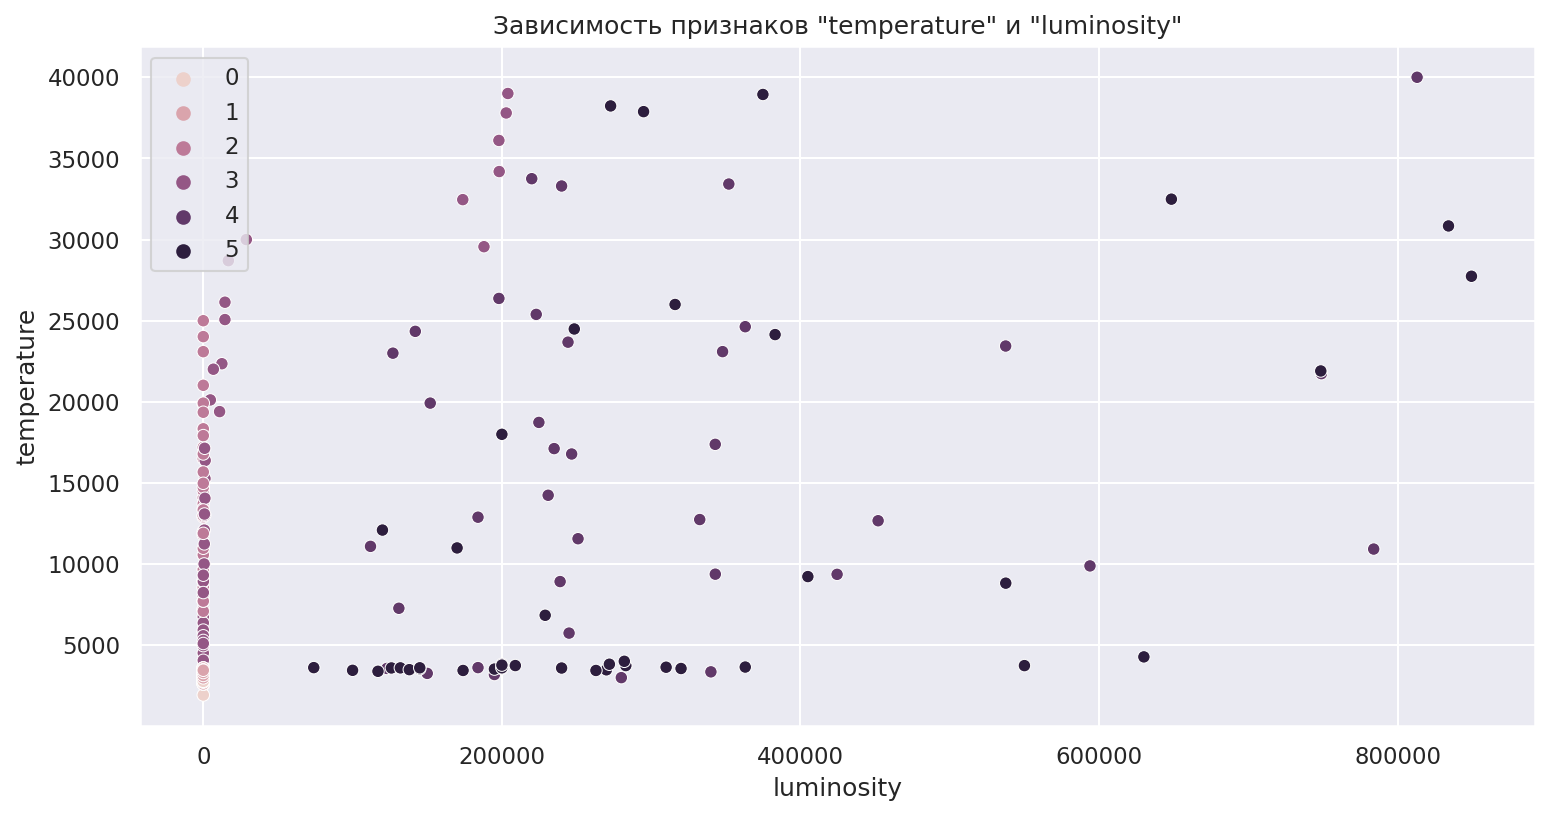

In [ ]:
target_num('luminosity', 'temperature', 'upper left')

<font size="3"> Половина звезд в датасете имеют светимость меньше, чем 0.071 L/Lo, на графике отмечается скопление наблюдений около 0.
    
Логарифмируем признаки и рассмотрим зависимость повторно.

In [ ]:
stars['temperature_log'] = np.log(stars['temperature'])
stars['luminosity_log'] = np.log(stars['luminosity'])

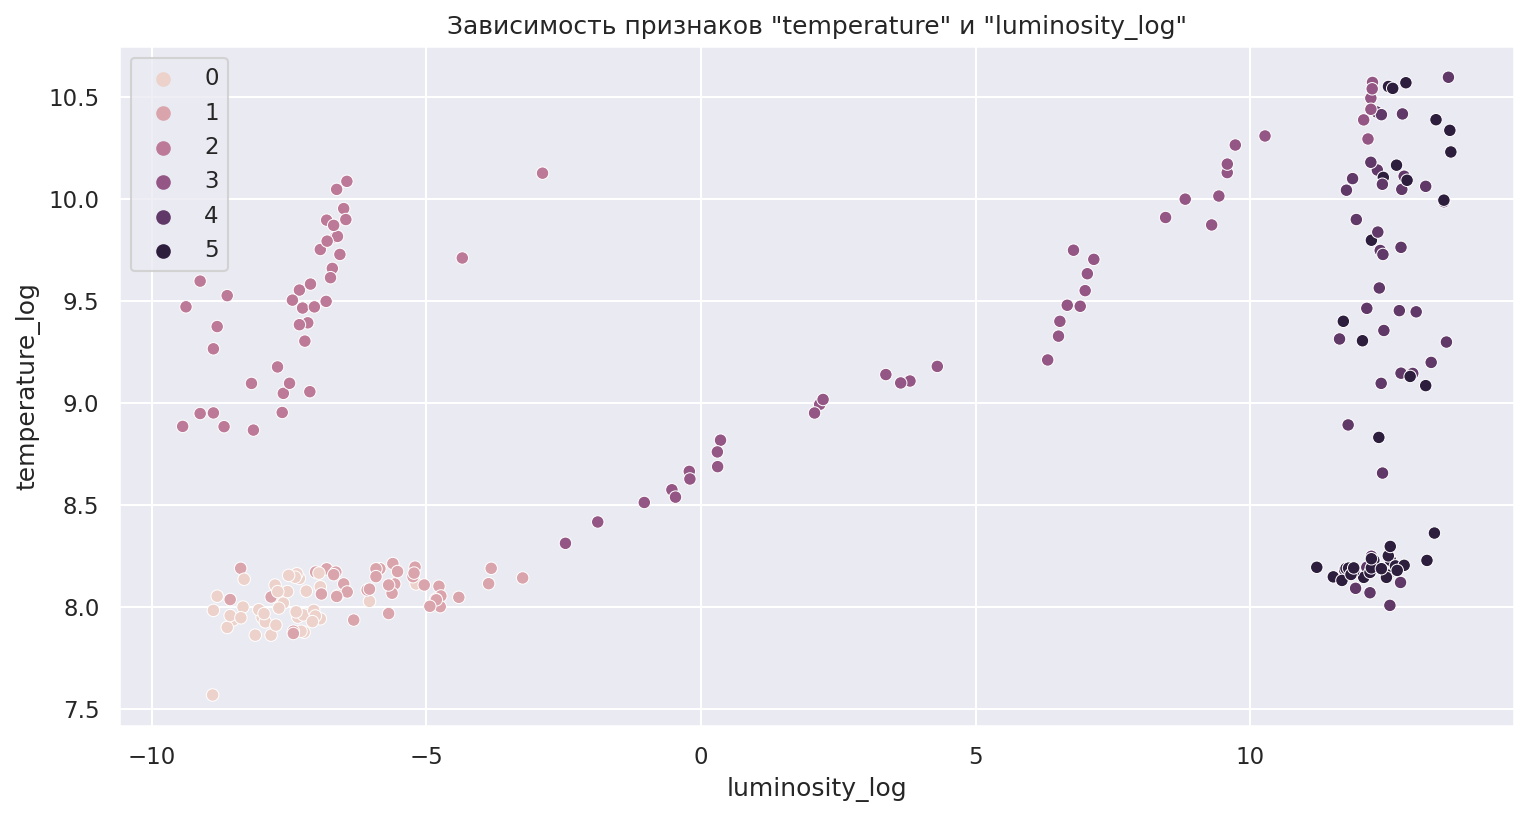

In [ ]:
target_num('luminosity_log', 'temperature_log', 'upper left')

<font size="3">
    
**Вывод**

Между логарифмами целевого признака `temperature` и входного признака `luminosity` отмечается некоторая зависимость.
    
Логарифмирование помогло избавиться от скученности наблюдений в области 0, также теперь на графике можно выделить несколько кластеров.
    
Также можно отметить, что относительная светимость звезд 4-го и 5-го типа имеет высокие (положительные) значения.

<font size="4">
    
> Признак **radius**

<font size="3">
    
Гистограмма распределения показала наличие выбросов и скопление наблюдений около 0. Логарифмируем признаки перед изучением зависимости.

In [ ]:
stars['radius_log'] = np.log(stars['radius'])

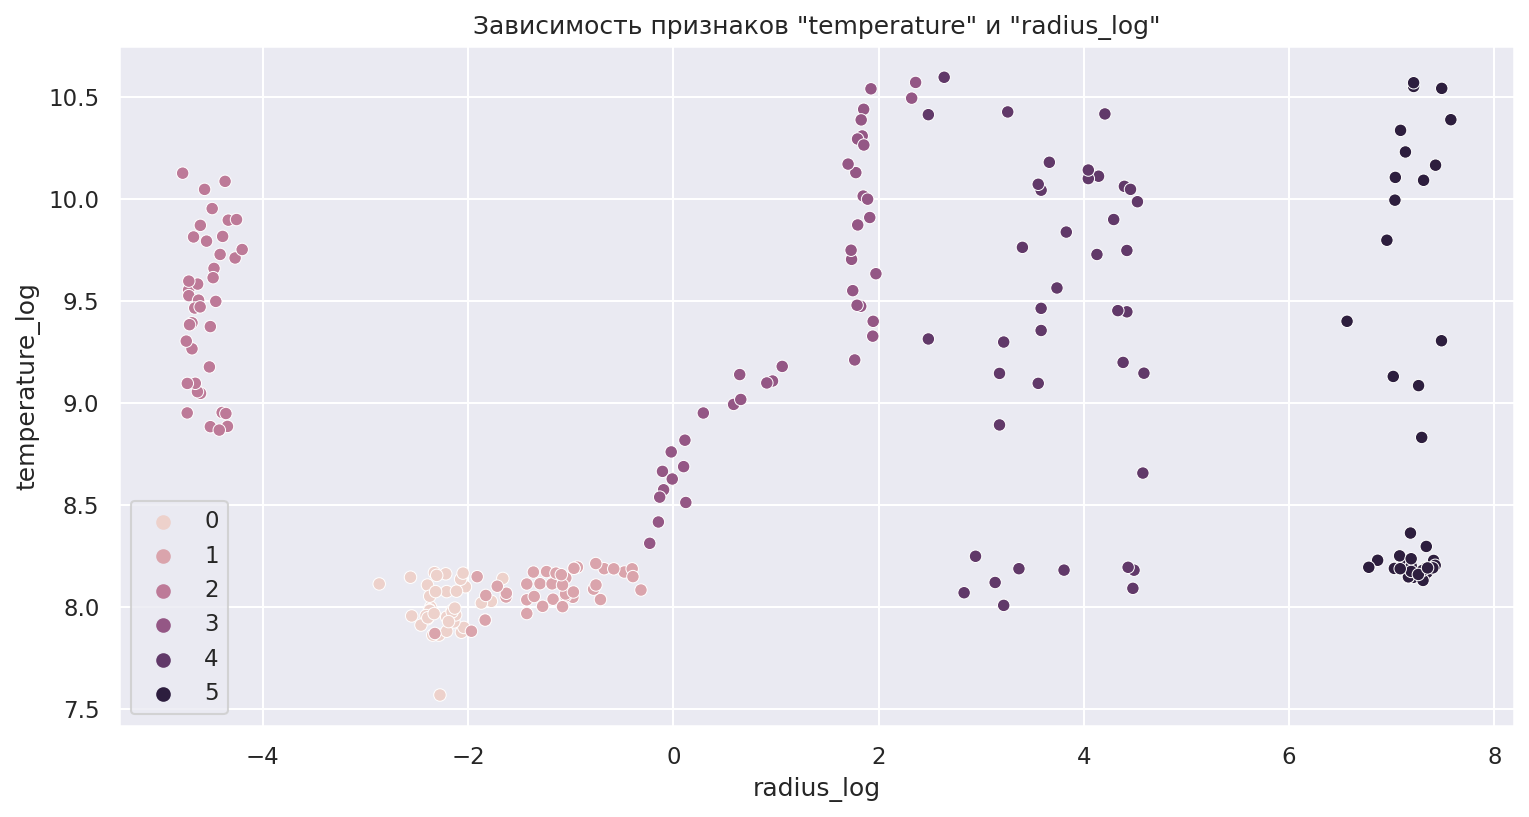

In [ ]:
target_num('radius_log', 'temperature_log', 'lower left')

<font size="3">
    
**Вывод**

На графике зависимости логарифмов целевого признака `temperature` и входного признака `radius` можно выделить несколько обособленных кластеров.
    
При этом нельзя сказать, что относительный радиус звезды связан с её температурой.

<font size="4">
    
> Признак **absolute_magnitude**

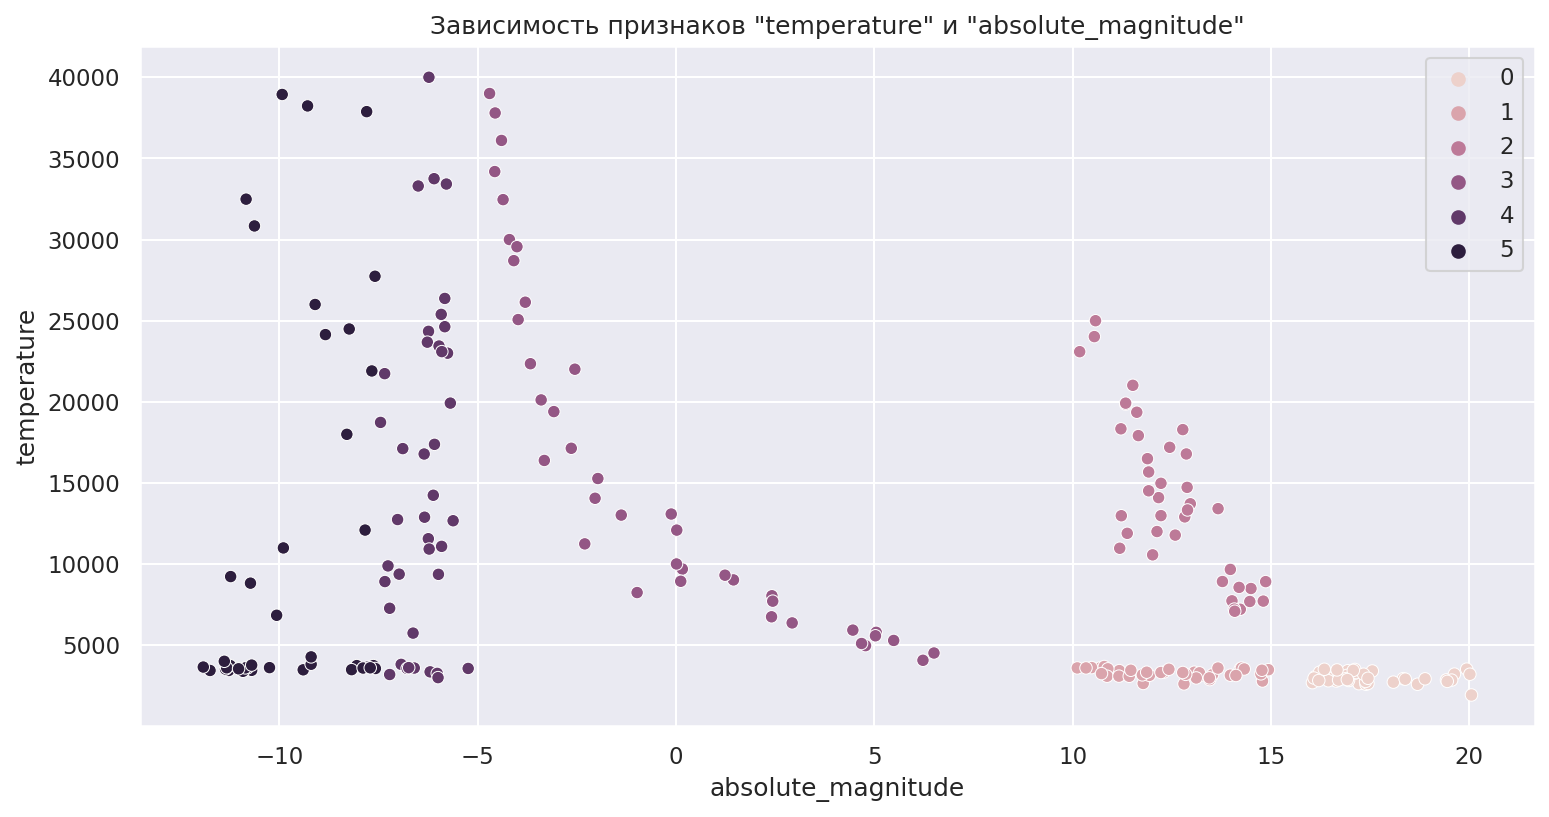

In [ ]:
target_num('absolute_magnitude', 'temperature', 'upper right')

<font size="3">
    
**Вывод**
    
На графике зависимости целевого признака `temperature` и входного признака `absolute_magnitude` можно выделить несколько обособленных кластеров, имеющих характерное распределение по температуре в зависимости от типа звезды.
    
Крупные звёзды **4-5 типов** имеют отрицательную абсолютную звездную величину и могут достигать высоких значений температуры.
    
Температура звёзд **2-3 типов** снижается с увеличением магнитуды звезды, дисперсия температуры звёзд 3-го типа больше, чем у звёзд 2-го типа.
    
Температура звёзд **0-1 типов** имеет самый низкий диапазон и также незначительно уменьшается линейно с увеличением абсолютной звездной величины.

---

<font size="3"> **Категориальные признаки**
    
    
Напишем функцию `target_cat` для отображения распределения целевого признака `temperature` в разрезе категориальных входных признаков.

In [ ]:
def target_cat(col):
    fig, ax = plt.subplots(figsize=(15,6), dpi=PLOT_DPI)

    sns.violinplot(data=stars, x=col, y='temperature', ax=ax)

    plt.title("Распределение признака 'temperature' в разрезе признака " + col)
    plt.xlabel("признак " + col)
    plt.ylabel("Признак 'temperature'");

<font size="3">
    
> Признак **star_color**

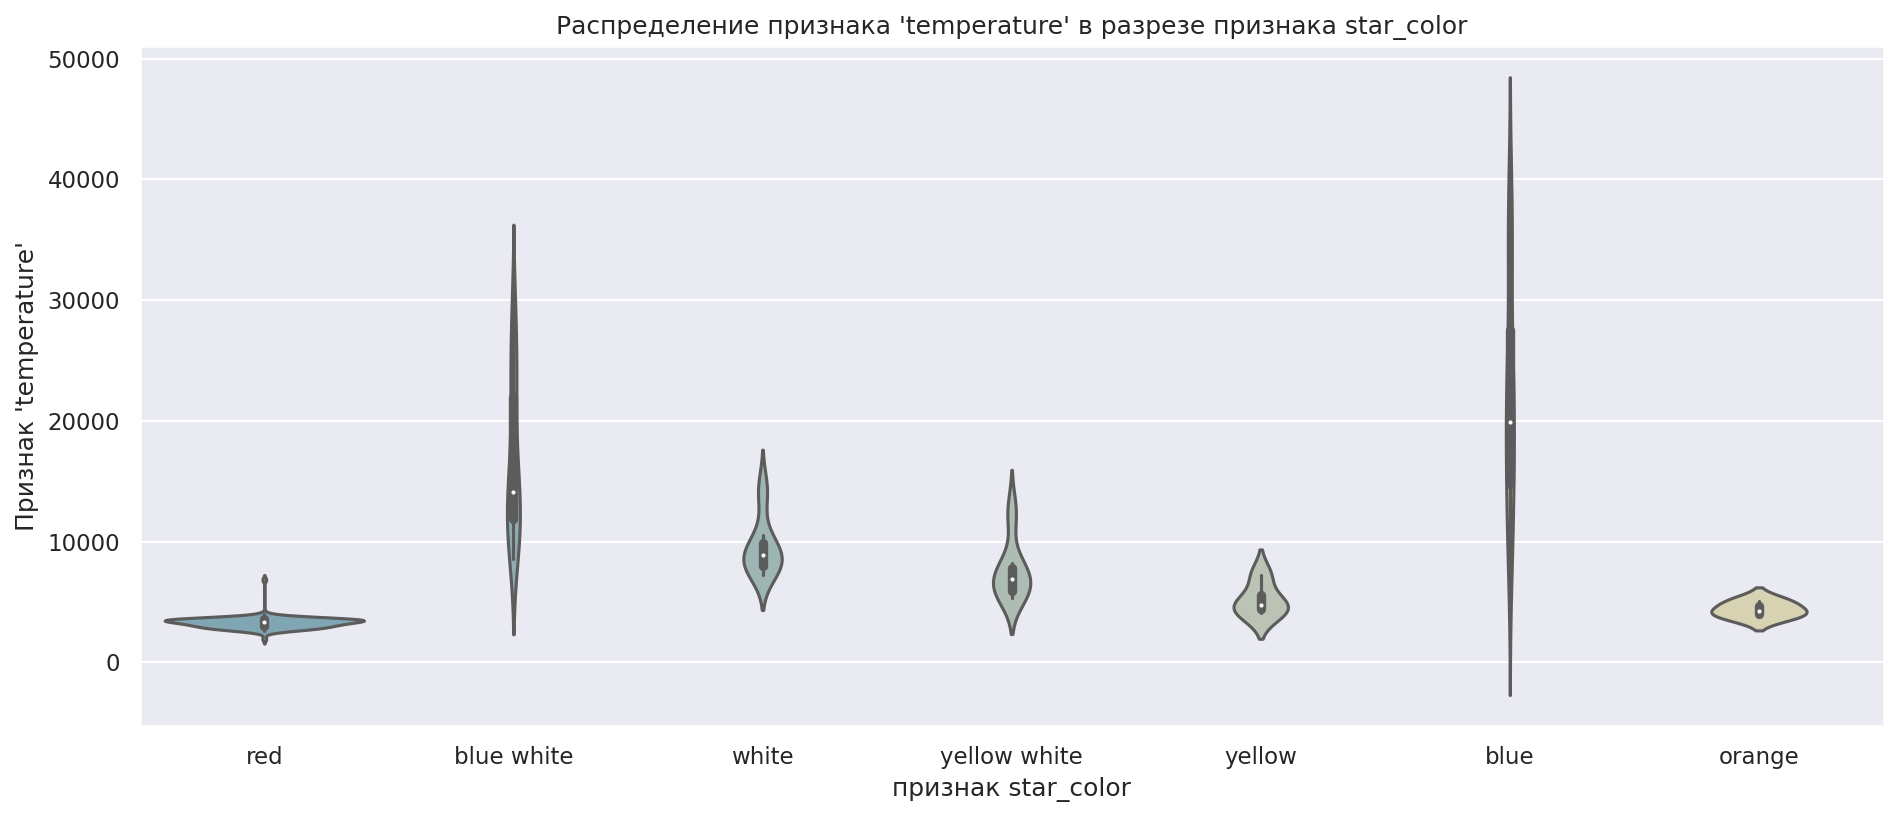

In [ ]:
target_cat('star_color')

<font size="3">
    
**Вывод**
    
Можно отметить, что наибольший диапазон температур у звёзд категории `blue` и `blue white`. Остальным цветам звёзд соответствует довольно узкий диапазон температур.
    
Также можно отметить, что данные не соответствуют стандартной классификации:
    
| Класс | Температура | Цвет |
|----------|----------|----------|
| O    | > 30 000   | Голубой   |
| B   | 10 000—30 000   | Бело-голубой   |
| A    | 7400—10 000   | Белый  |
| F    | 6000—7400  | Жёлто-белый   |
| G   | 5000—6000   | Жёлтый   |
| K  | 3800—5000   | Оранжевый   |
| M   | 2500—3800   | Красный  |
    
Из чего можно сделать вывод, что спектральный класс определяется не только температурой звезды, но и иными свойствами: химический состав, поглощение, видимость итд.

<font size="4">
    
> Признак **star_type**

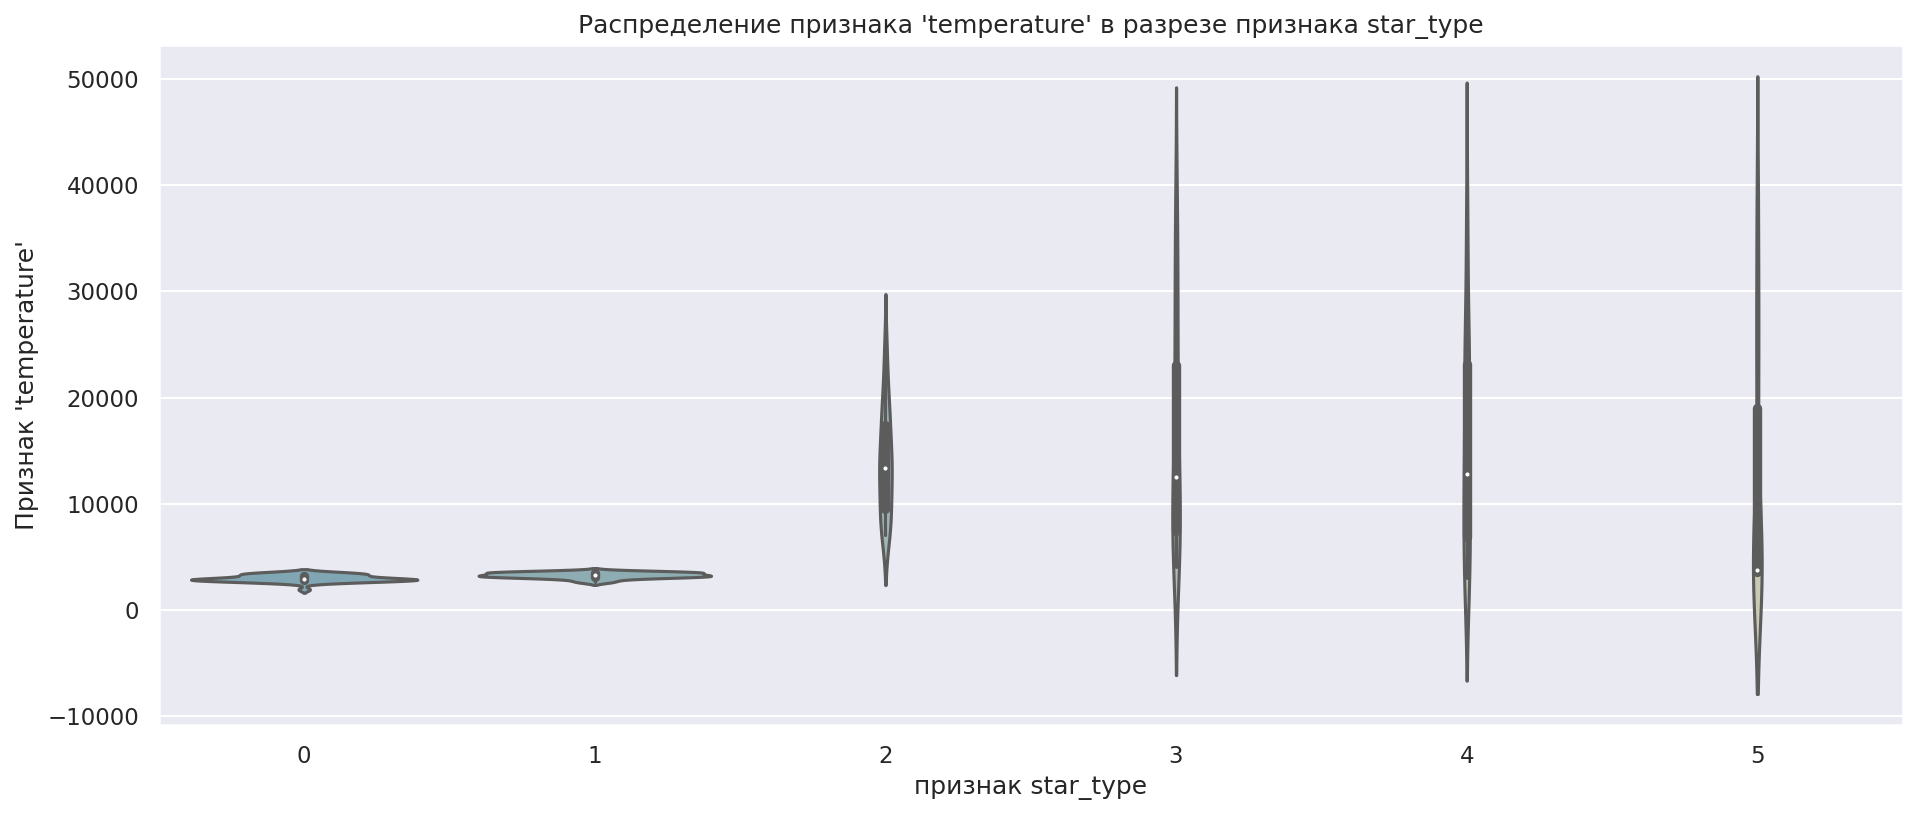

In [ ]:
target_cat('star_type')

<font size="3">
    
**Вывод**
    
Можно отметить, что наибольший диапазон температур у типов звёзд с 3-го по 5-й.
    
У звёзд 2-го типа средняя дисперсия температур: до 30 000 Кельвинов.
    
Остальным типам звёзд соответствует довольно узкий диапазон низких температур.

<font size="3">
    
**Вывод раздела**
    
Корреляционный анализ признаков помог выявить некоторые характерные особенности звёзд.

> **Горячие звёзды:**
- представлены в выборке меньше, чем холодные звёзды (возможно, реже встречаются в ближайшем космосе);
- имеют белый и голубой цвет;
- имеют отрицательную абсолютную звёздную величину;
- имеют со 2-го по 5-й тип звезды: Белые карлики, Звёзды главной последовательности, Сверхгиганты, Гипергиганты;
- могут иметь как большой, так и малый относительный радиус;
- имеют более высокое значение относительной светимости.
    
> **Холодные звёзды:**
- представлены в выборке чаще, чем более холодные звёзды;
- чаще имеют красный цвет;
- имеют высокую (положительную) абсолютную звёздную величину;
- имеют 0-й или 1-й тип звезды: Коричневый карлик или Красный карлик;
- имеют небольшой относительный радиус;
- имеют низкое значение относительной светимости.

### Матрица корреляции

<font size="3"> Корреляцию признаков рассмотрим с помощью матрицы корреляций `phik_matrix()`.

In [ ]:
# функция построения матрицы корреляций phik
def phik_matrix(df):
    # список интервальных признаков
    interval_cols = df.select_dtypes(include='number').columns.tolist()

    # вычисление коэффициентов корреляции phi для датафрейма
    phik_overview = df.phik_matrix(interval_cols=interval_cols)

    # визуализация тепловой карты коэффициентов корреляции
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        title=r"Матрица корреляции $\phi_K$",
        fontsize_factor=1.5,
        figsize=(20, 10)
    )

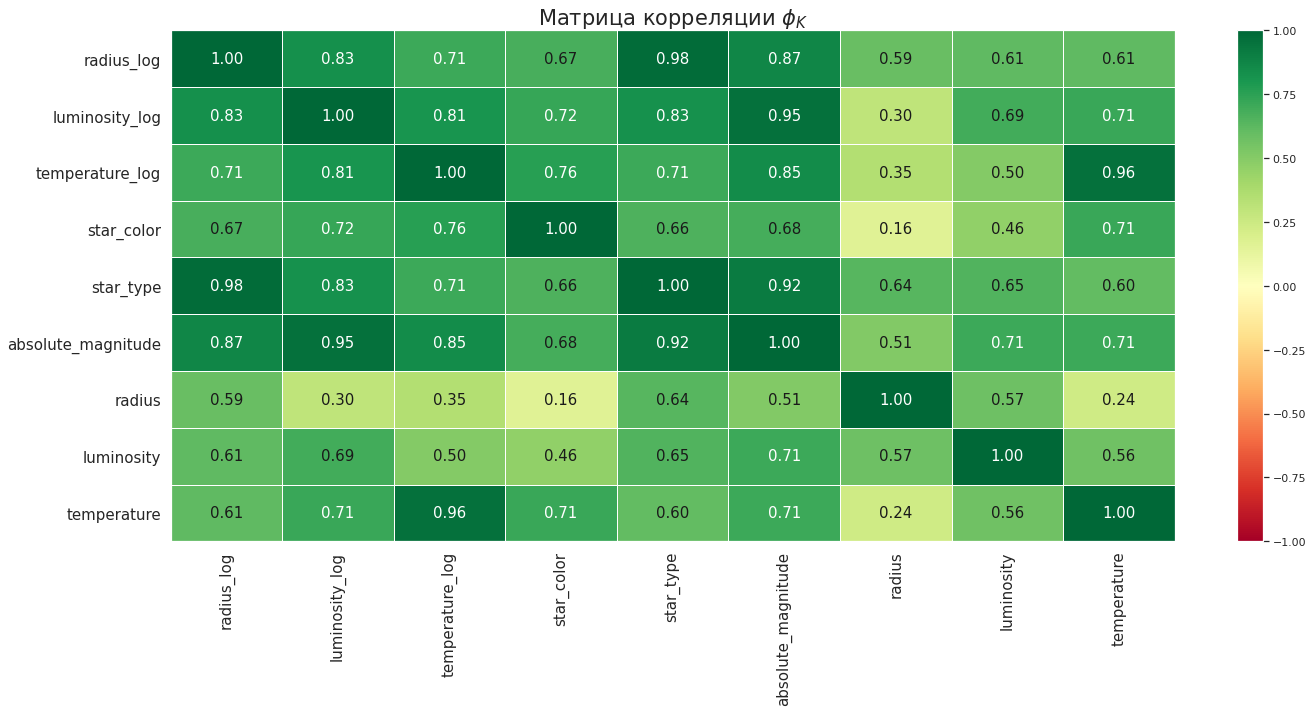

In [ ]:
phik_matrix(stars)

<font size="3">
Матрица корреляции обнаруживает сильные нелинейные взаимосвязи между целевым и входными признаками. Также на графике отмечается мультиколлинеарность признакового описания.
    

<br>Нейронные сети могут эффективно обнаруживать и моделировать сложные нелинейные взаимосвязи в данных, оставим в датафрейме логарифмированные варианты признаков, чтобы ещё упростить работу модели.

In [ ]:
stars = stars.drop(columns=['temperature_log', 'luminosity', 'radius'])

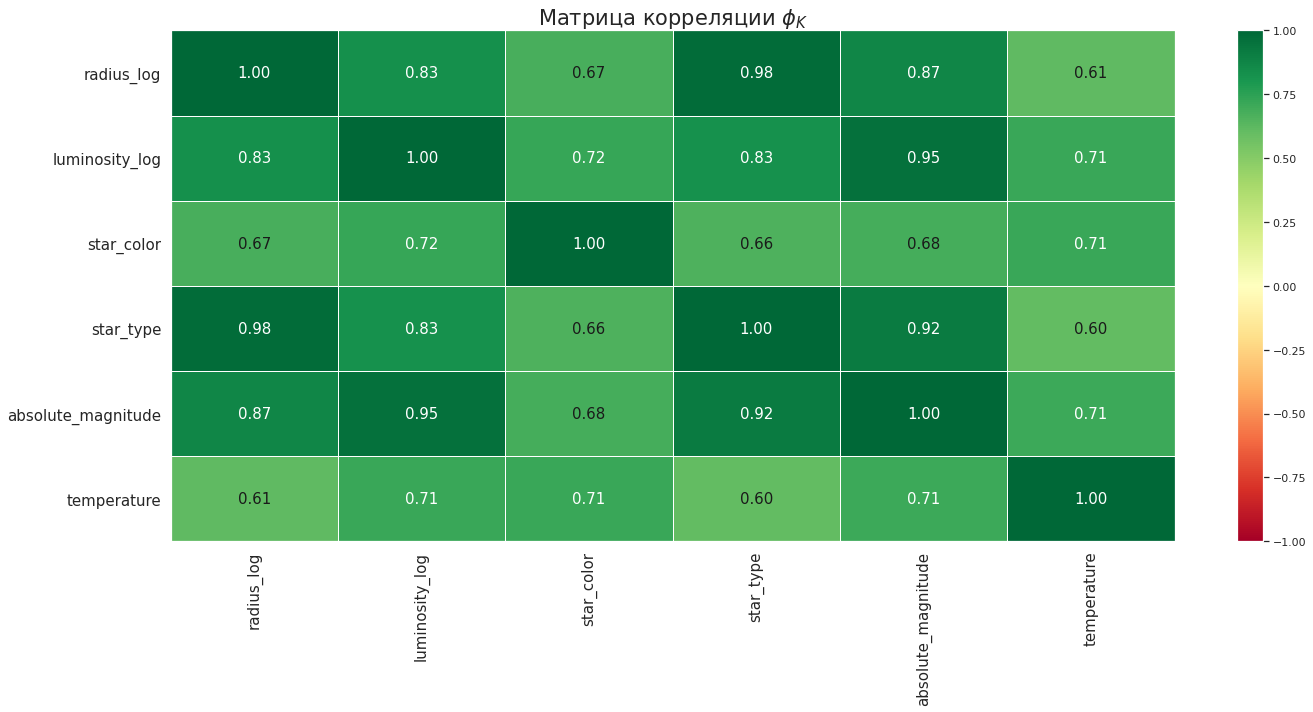

In [ ]:
phik_matrix(stars)

---

<font size="3">

**Вывод раздела**

Каждый из входных признаков имеет высокую зависимость с целевым признаком `temperature`.
    
Выявлена мультиколлинеарность признакового описания, для предотвращения переобучения модели подберём оптимальное значение параметра Dropout в ходе обучения.    
    
По результатам исследовательского и корреляционного анализа можно сделать вывод, что признаковое описание содержит выбросы.
    
При этом, размер имеющихся данных не позволяет удалить выбивающиеся значения, поэтому для дальнейшего исследования будут использованы логарифмированные версии признаков.

---

## Подготовка данных

<font size="3">
    
В данном шаге подготовим данные к построению модели:
   
- сформируем выборки;
- проведём предобработку;
- получим тензоры для модели.

### Формирование выборок

<font size="3"> Сформируем выборки:

In [ ]:
# обозначим входные и целевой признаки
X = stars.drop('temperature', axis=1)
y = stars['temperature']

# разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE,
)

# создадим списки с названиями признаков
ohe_columns = ['star_type', 'star_color']
num_columns = ['absolute_magnitude', 'luminosity_log', 'radius_log']

### Предобработка данных

<font size="3"> Подготовим данные к построению модели:

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков + OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# трансформируем признаки для обучения полученной моделью с помощью data_preprocessor()
X_train = pd.DataFrame(data_preprocessor.fit_transform(X_train))
X_test = pd.DataFrame(data_preprocessor.transform(X_test))

### Получение тензора

<font size="3"> Создадим из полученных выборок тензор:

In [ ]:
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values)

## Построение базовой нейронной сети

<font size="3"> Создадим базовую модель нейросети.

In [ ]:
# определение архитектуры нейронной сети
class NeuralNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.relu1 = nn.LeakyReLU()
        self.dp2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dp2(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

<font size="3">
    
Напишем класс для реализации ранней остановки для контроля переобучения модели.

In [ ]:
class CustomEarlyStopping():
    '''
    Выполняет остановку обучения, если функция потерь не улучшается после определенного количества эпох.
    '''
    def __init__(self, patience=5, min_delta=0):
        '''
        patience: количество эпох для ожидания улучшения значения функции потерь
        min_delta: минимальное значение, считаемое улучшением значения функции потерь
        '''
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

<font size="3"> Инициализация сети.

In [ ]:
# инициализируем функцию ранней остановки
early_stoping = CustomEarlyStopping(min_delta=30)

# параметры Baseline модели
n_in_neurons = X_train.shape[1]  # количество входных нейронов
n_hidden_neurons_1 = 10          # количество нейронов в первом скрытом слое
n_hidden_neurons_2 = 5          # количество нейронов во втором скрытом слое
n_out_neurons = 1                # количество выходных нейронов
dropout_rate = 0                 # величина dropout, не используется в базовой модели


num_epochs = 5000 # количество эпох обучения
learning_rate = 0.05 # скорость обучения

<font size="3"> Параметры сети.

In [ ]:
# экземпляр нейронной сети
model = NeuralNet(
    n_in_neurons,
    n_hidden_neurons_1,
    n_hidden_neurons_2,
    n_out_neurons,
    dropout_rate
)
loss = nn.MSELoss() # функция потерь (используем MSE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # оптимизатор

#параметры базовой модели
summary(model, X_train.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 180, 10]             150
         LeakyReLU-2              [-1, 180, 10]               0
           Dropout-3              [-1, 180, 10]               0
            Linear-4               [-1, 180, 5]              55
         LeakyReLU-5               [-1, 180, 5]               0
            Linear-6               [-1, 180, 1]               6
Total params: 211
Trainable params: 211
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.00
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


<font size="3"> Функция для обучения сети.

In [ ]:
def train_model(model, optimizer, loss, X_train, y_train, X_test, y_test, num_epochs, patience, min_delta, batch_size):

    test_lost = []
    best_rmse = np.inf
    best_predictions = None

    early_stopper = CustomEarlyStopping(patience=patience, min_delta=min_delta)

    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()

        preds = model.forward(X_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 30 == 0 or epoch == num_epochs - 1:
            model.eval()
            test_preds = model.forward(X_test).flatten()

            # Рассчитайте  RMSE  с  помощью  mean_squared_error
            rmse = mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy(), squared=False)

            test_lost.append(rmse)

            print(f'Эпоха №{epoch}, RMSE на тестовой выборке: {rmse}')

            # сохранение лучшего результата
            if rmse < best_rmse:
                best_rmse = rmse
                best_predictions = test_preds

            #  Остановка  обучения
            early_stopper(rmse)
            if early_stopper.early_stop:
                print('Early Stopping!!!')
                print(f'Best RMSE test {best_rmse}')
                break

    return best_rmse, best_predictions

### Обучение baseline-модели

In [ ]:
best_rmse_baseline, predictions_baseline = train_model(
    model,
    optimizer,
    loss,
    X_train,
    y_train,
    X_test,
    y_test,
    num_epochs,
    batch_size=32,
    patience=10,
    min_delta=1e-4
)

Эпоха №0, RMSE на тестовой выборке: 15460.423828125
Эпоха №30, RMSE на тестовой выборке: 15297.3720703125
Эпоха №60, RMSE на тестовой выборке: 13537.0859375
Эпоха №90, RMSE на тестовой выборке: 10126.609375
Эпоха №120, RMSE на тестовой выборке: 9172.48828125
Эпоха №150, RMSE на тестовой выборке: 8546.767578125
Эпоха №180, RMSE на тестовой выборке: 8138.55615234375
Эпоха №210, RMSE на тестовой выборке: 7623.80859375
Эпоха №240, RMSE на тестовой выборке: 7150.83642578125
Эпоха №270, RMSE на тестовой выборке: 6723.26611328125
Эпоха №300, RMSE на тестовой выборке: 6299.703125
Эпоха №330, RMSE на тестовой выборке: 5912.798828125
Эпоха №360, RMSE на тестовой выборке: 5542.16162109375
Эпоха №390, RMSE на тестовой выборке: 5194.00390625
Эпоха №420, RMSE на тестовой выборке: 4915.04150390625
Эпоха №450, RMSE на тестовой выборке: 4727.458984375
Эпоха №480, RMSE на тестовой выборке: 4614.46728515625
Эпоха №510, RMSE на тестовой выборке: 4533.45166015625
Эпоха №540, RMSE на тестовой выборке: 4463.

<font size="3">

Лучший результат достигнут на 1740 эпохе, метрика RMSE на тестовой выборке - 3973 Kельвинов, что уже удовлетворяет условию Заказчика (RMSE < 4500 K).

После 1740 эпохи модель переобучается и качество модели на тестовой выборке постепенно падает до срабатывания функции ранней остановки.

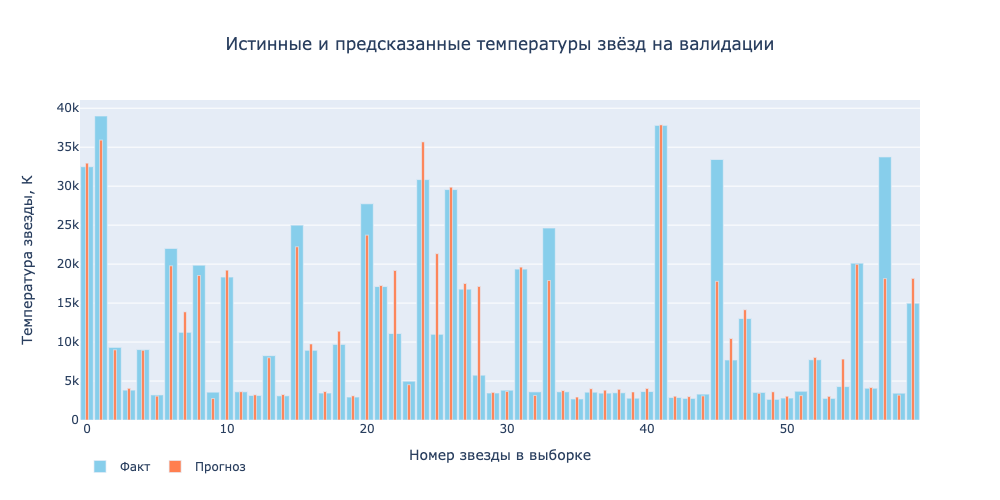

In [8]:
# построение графика
test_fig = go.Figure()
test_fig.add_trace(go.Bar(
    x=np.array(range(len(y_test))),
    y=y_test,
    name='Факт',
    width=.9,
    marker_color='skyblue'
    ))
test_fig.add_trace(go.Bar(
    x=np.array(range(len(predictions_baseline))),
    y=predictions_baseline.flatten().detach(),
    name='Прогноз',
    width=.2,
    marker_color='coral'
    ))
test_fig.update_layout(
    barmode='overlay',
    width=1000,
    height=500,
    legend_orientation='h',
    title=dict(
        text='Истинные и предсказанные температуры звёзд на валидации',
        x=.5
        ),
    xaxis_title='Номер звезды в выборке',
    yaxis_title='Температура звезды, К'
    )
test_fig.show()

<font size="3">
    
**Вывод**
    
Можно отметить, что модель чаще ошибается на больших температурах.
    
Возможно это связано с тем, что в нашей выборке значительно преобладают звёзды с диапазоном температур до 5000 Кельвинов, здесь модель справилась отлично.
    
При этом, ошибка модели более критично отражается на звёздах узкого диапазона температур (0-5000), нежели для звёзд с широким пределом значений (> 30 000).

## Улучшение нейронной сети

<font size="3">

С помощью библиотек `Scorch` и `Optuna` подберём для созданной модели следующие гиперпараметры:
    
- `learning_rate`
- `batch_size`
- `patience`
- `dropout_rate`

In [ ]:
# отключение вывода
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
# функция для подбора гиперпараметров с помощью Optuna
def objective(trial):

    # количество нейронов
    n_in_neurons = X_train.shape[1]
    n_hidden_neurons_1 = 10
    n_hidden_neurons_2 = 5
    n_out_neurons = 1


    # подбор гиперпараметров
    lr = trial.suggest_float('learning_rate', 0.05, 0.2) # скорость обучения
    batch_size = trial.suggest_int('batch_size', 32, 120, step=10) # размер пакета обучения
    patience = trial.suggest_int('patience', 10, 100, step=5) # количество шагов до остановки обучения
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.9, step=0.1) # dropout

    # модель
    model = NeuralNet(
        n_in_neurons,
        n_hidden_neurons_1,
        n_hidden_neurons_2,
        n_out_neurons,
        dropout_rate
    )

    loss = nn.MSELoss() # функция потерь
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # оптимизатор


   # отключение вывода обучения модели
    with SuppressOutput():
        # обучение модели
        best_rmse, _ = train_model(
            model,
            optimizer,
            loss,
            X_train,
            y_train,
            X_test,
            y_test,
            num_epochs=num_epochs,
            patience=patience,
            min_delta=1e-4,
            batch_size=batch_size)

    return best_rmse

In [ ]:
# создадим объект study
study = optuna.create_study(direction="minimize")

# запустим процесс оптимизации
study.optimize(objective, n_trials=30)

[I 2025-02-08 10:22:27,482] A new study created in memory with name: no-name-467fdef2-1ea3-447d-960c-9b64019d3f0a
[I 2025-02-08 10:22:48,450] Trial 0 finished with value: 4376.72314453125 and parameters: {'learning_rate': 0.199461868437471, 'batch_size': 42, 'patience': 100, 'dropout_rate': 0.7000000000000001}. Best is trial 0 with value: 4376.72314453125.
[I 2025-02-08 10:23:00,758] Trial 1 finished with value: 3939.309326171875 and parameters: {'learning_rate': 0.14230286484096102, 'batch_size': 112, 'patience': 20, 'dropout_rate': 0.30000000000000004}. Best is trial 1 with value: 3939.309326171875.
[I 2025-02-08 10:23:21,761] Trial 2 finished with value: 3901.779052734375 and parameters: {'learning_rate': 0.05190958698085481, 'batch_size': 72, 'patience': 70, 'dropout_rate': 0.2}. Best is trial 2 with value: 3901.779052734375.
[I 2025-02-08 10:23:41,758] Trial 3 finished with value: 3938.21142578125 and parameters: {'learning_rate': 0.14391105000147442, 'batch_size': 62, 'patience':

<font size="3">
    
Выведем результат подбора параметров.

In [ ]:
# вывод лучшей метрики Optuna
print(f'Лучшее значение RMSE: {round(study.best_trial.values[0])}')

Лучшее значение RMSE: 3853


In [ ]:
# вывод лучших найденных гиперпараметров Optuna
print("Лучшие найденные гиперпараметры:")
print(study.best_params)

Лучшие найденные гиперпараметры:
{'learning_rate': 0.19007430206025672, 'batch_size': 92, 'patience': 80, 'dropout_rate': 0.2}


<font size="3"> Проверим модель с лучшими параметрами на тестовой выборке.

In [ ]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 5
n_out_neurons = 1

# инициализация модели с лучшими гиперпараметрами
model = NeuralNet(
    n_in_neurons,
    n_hidden_neurons_1,
    n_hidden_neurons_2,
    n_out_neurons,
    study.best_params['dropout_rate']
)

loss = nn.MSELoss()  # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr=study.best_params['learning_rate'])  # оптимизатор

In [ ]:
# обучение модели с лучшими гиперпараметрами
best_rmse, predictions = train_model(
    model,
    optimizer,
    loss,
    X_train,
    y_train,
    X_test,
    y_test,
    num_epochs=num_epochs,
    patience=study.best_params['patience'],
    min_delta=1e-4,
    batch_size=study.best_params['batch_size']
)

Эпоха №0, RMSE на тестовой выборке: 15459.662109375
Эпоха №30, RMSE на тестовой выборке: 10681.7177734375
Эпоха №60, RMSE на тестовой выборке: 8258.2666015625
Эпоха №90, RMSE на тестовой выборке: 7134.49462890625
Эпоха №120, RMSE на тестовой выборке: 5355.54736328125
Эпоха №150, RMSE на тестовой выборке: 4685.5810546875
Эпоха №180, RMSE на тестовой выборке: 4398.4755859375
Эпоха №210, RMSE на тестовой выборке: 4402.142578125
INFO: Early stopping counter 1 of 80
Эпоха №240, RMSE на тестовой выборке: 4162.18505859375
Эпоха №270, RMSE на тестовой выборке: 4118.03955078125
Эпоха №300, RMSE на тестовой выборке: 4161.5146484375
INFO: Early stopping counter 1 of 80
Эпоха №330, RMSE на тестовой выборке: 4039.790771484375
Эпоха №360, RMSE на тестовой выборке: 4183.6552734375
INFO: Early stopping counter 1 of 80
Эпоха №390, RMSE на тестовой выборке: 4052.639404296875
INFO: Early stopping counter 2 of 80
Эпоха №420, RMSE на тестовой выборке: 3987.122802734375
Эпоха №450, RMSE на тестовой выборке:

In [ ]:
# вывод лучшей метрики
print(f"Лучшая метрика RMSE на X_test: {best_rmse}")

Лучшая метрика RMSE на X_test: 3873.6005859375


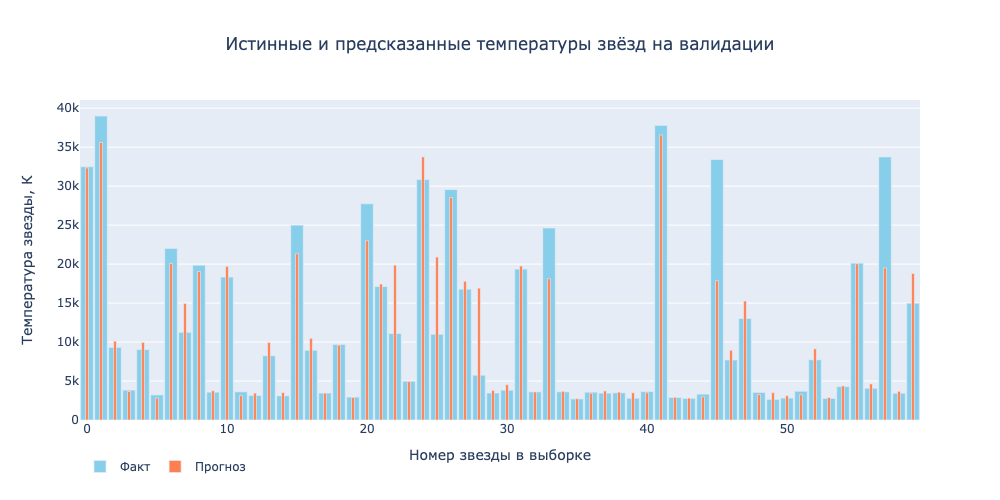

In [10]:
# построение графика "Факт - Прогноз"
test_fig = go.Figure()
test_fig.add_trace(go.Bar(
    x=np.array(range(len(y_test))),
    y=y_test,
    name='Факт',
    width=.9,
    marker_color='skyblue'
    ))
test_fig.add_trace(go.Bar(
    x=np.array(range(len(predictions))),
    y=predictions.flatten().detach(),
    name='Прогноз',
    width=.2,
    marker_color='coral'
    ))
test_fig.update_layout(
    barmode='overlay',
    width=1000,
    height=500,
    legend_orientation='h',
    title=dict(
        text='Истинные и предсказанные температуры звёзд на валидации',
        x=.5
        ),
    xaxis_title='Номер звезды в выборке',
    yaxis_title='Температура звезды, К'
    )
test_fig.show()

<font size="3">
    
**Вывод**
    
Выводы по работе улучшенной модели нейронной сети:

- с помощью библиотеки `Optuna` было создано решение для подбора гиперпараметров нейронной сети, основанной на базовой модели;
- удалось достичь улучшения качества модели по сравнению с базовой версией, что говорит о более точном предсказании температуры звезд;   
- результат лучшей модели: RMSE на тестовой выборке ~ 3856 K, что ниже порога, установленного Заказчиком (< 4500 К).

## Общий вывод

<font size="3">
    
Целью данного исследования являлась разработка нейронной сети, которая поможет предсказывать абсолютную температуру на поверхности звезды.
    
В рамках данного проекта был проведен анализ и предобработка данных, а также написаны и проверены на данных две нейронные сети.

> **Исследовательский анализ**
    
<br> Выявлены и исправлены спектральные классы звёзд, отсутствующие в стандартной классификации.
<br> Исследованы зависимости целевого признака от входных признаков.
<br> Установлено, что зависимости, как правило, нелинейные.
<br> Выявлена тенденция к образованию кластеров.
<br> По итогам проведённого анализа сформулированы характерные описания "холодных" и "горячих" звёзд.

> **Подготовка данных для модели**

Признаки `absolute_magnitude`,  `luminosity` и `radius` были логарифмированы из-за наличия выбивающихся значений.

Создан пайплайн подготовки данных для модели, который включает скалирование числовых и кодирование категориальных признаков.

> **Простая модель**

Написана базовая модель, которая показала результат, соответствующий условиям Заказчика - **3973 Kельвинов**. Модель показала неплохую способность предсказывать температуру звёзд, но на графике "Факт - Прогноз" была заметна тенденция предсказывать более усреднённые значения для наиболее горячих звёзд.

> **Улучшенная модель**

Для улучшения модели использован подбор гиперпараметров с помощью `Optuna`: `learning_rate`, `batch_size`, `patience` и `dropout_rate`.
    
После подбора параметров удалось достичь улучшения качества модели по сравнению с базовой версией. Значения метрики `RMSE_test` уменьшилось до **~3856 K**, что говорит о более точном предсказании температуры звёзд.
    
> **Рекомендации и риски**

- для повышения качества модели стоит увеличить количество наблюдений и признаков;
- температура многих звёзд не соотвествует их спектральному классу, стоит исследовать эту особенность подробнее;
- дополнительно повысить качество модели помогут новые признаки: с использованией выявленной кластеризации или с помощью метода главных компонент (PCA);
- также стоит исследовать иные архитектуры сетей, оптимизировать параметры обучения и проверить дополнительные гиперпараметры модели.